In [1]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile, effective_yield, stellar_gas_densities, gasmetals_only, stellar_gas_metallicities, gas_mass, bimodal_check, starmetals_only, stellar_mass, get_stellar_age, gas_consumption

redshift = 0

Load pre-calculated data from file: ```galaxy_population_data_2.hdf5``` for faster execution.

In [2]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
    FeH_Re = f['FeH_Re'][:]
    MgFe_Re = f['MgFe_Re'][:]
    MgH_Re = f['MgH_Re'][:]
    FeH_1kpc = f['FeH_1kpc'][:]
    MgFe_1kpc = f['MgFe_1kpc'][:]
    MgH_1kpc = f['MgH_1kpc'][:]
    gas_mass_1kpc = f['gas_mass_1kpc'][:]
    stellar_mass_1kpc = f['stellar_mass_1kpc'][:]

Now apply the selection criteria for star-forming, young quiescent (post-starburst), intermediate, and old quiescent galaxies at $z=2$.

In [3]:
import warnings
warnings.filterwarnings('ignore')

starforming_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))>-2.2)
quiescent_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))<=-2.2)

In [15]:
print(len(ids[starforming_selection]))
print(len(ids[quiescent_selection]))

406
2449


## bimodal

1 

D:\Pathak_2021\simulation_data\galaxies\galaxy.py:1485: RuntimeWarning: divide by zero encountered in log10
  return np.log10(total_mass)


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

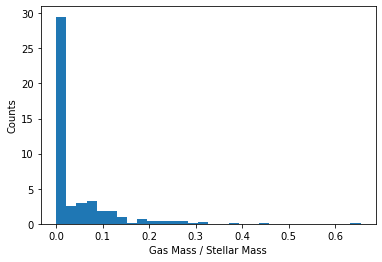

In [3]:
big_hist = []
i = 0
for id in np.random.choice(ids, 1000, replace=False):
    i += 1
    print(str(i), end=' ')
    mass_gas = 10**gas_mass(id=id, redshift=redshift)
    if mass_gas == 0:
        pass
    else:
        mass_star = 10**total_mass[ids==id] / 2
        big_hist.append(float(mass_gas / mass_star))
# print(big_hist)
plt.hist(big_hist, bins=30, density=True)
plt.xlabel('Gas Mass / Stellar Mass')
plt.ylabel('Counts')
plt.show()
    


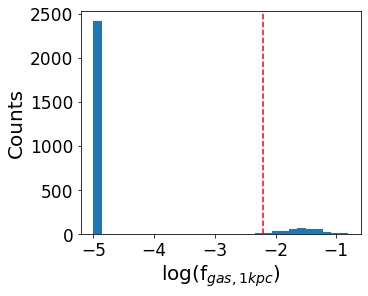

In [6]:
fig = plt.figure(1,figsize=(5,4), constrained_layout=True)
fig.clf()
fts = 20

big_hist = np.log10(gas_mass_1kpc / (gas_mass_1kpc + stellar_mass_1kpc))
# np.nan_to_num(big_hist, copy=False, nan=0.0, neginf=0.0)
big_hist[big_hist<-5] = -5
# print(big_hist)
plt.hist(big_hist, bins=30, range=(-5, -0.8), density=False)
plt.axvline(x=-2.2, linestyle='--', color='r')
plt.xlabel('log(f$_{gas, 1kpc}$)', fontsize=fts)
plt.ylabel('Counts', fontsize=fts)
plt.tick_params(labelsize=fts-3)
# plt.xlim(0, 0.7)

# plt.savefig('2022 FIGURES/bimodal.png', dpi=400)

plt.show()

# Stellar Metallicity

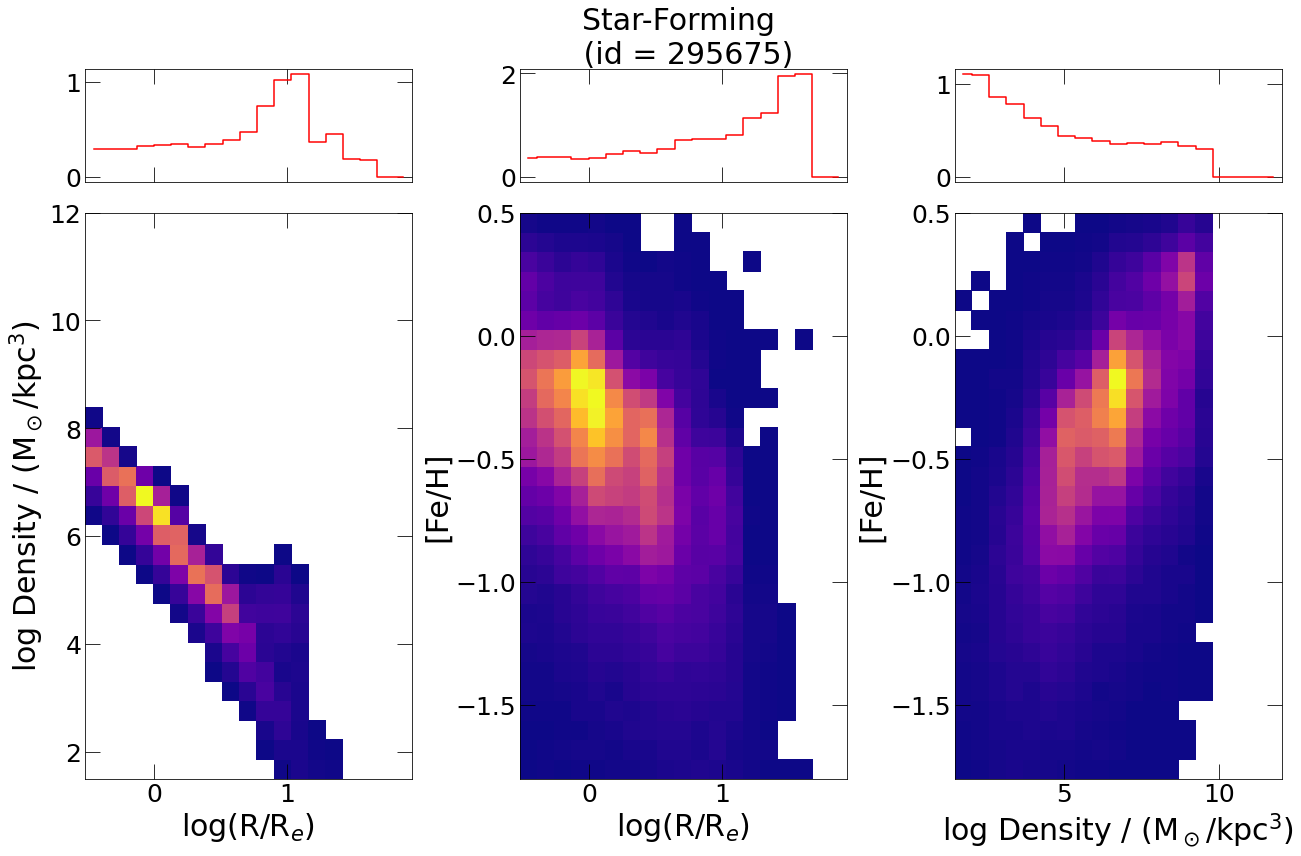

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

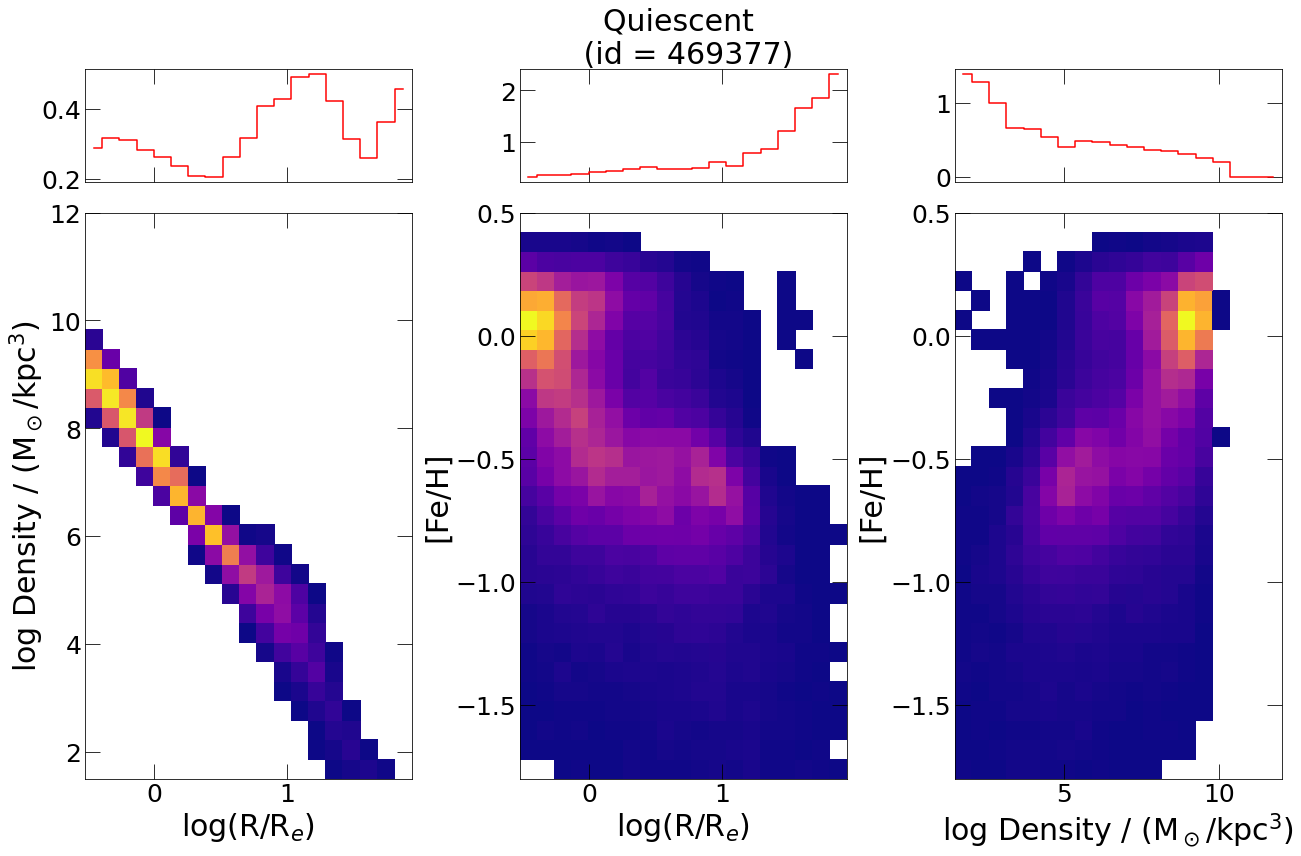

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

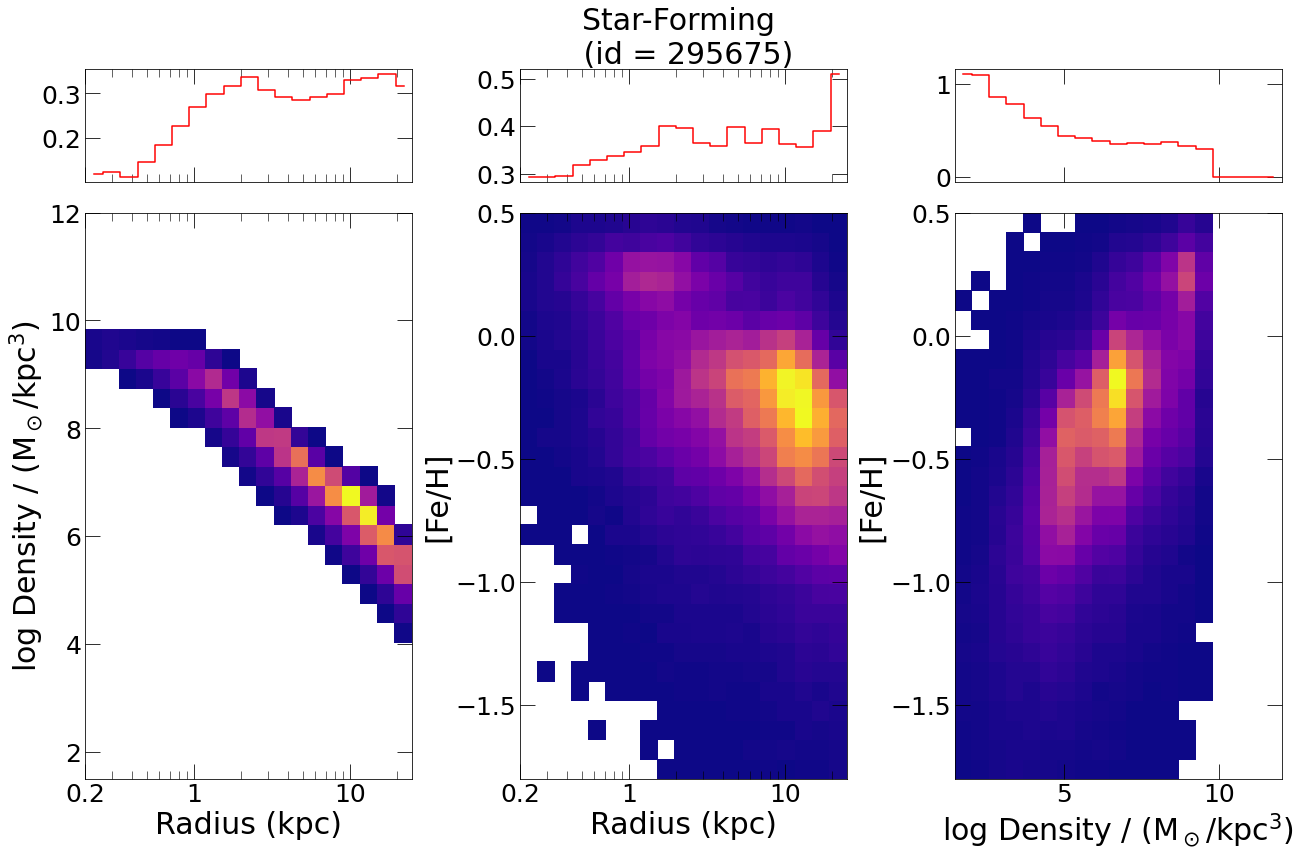

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

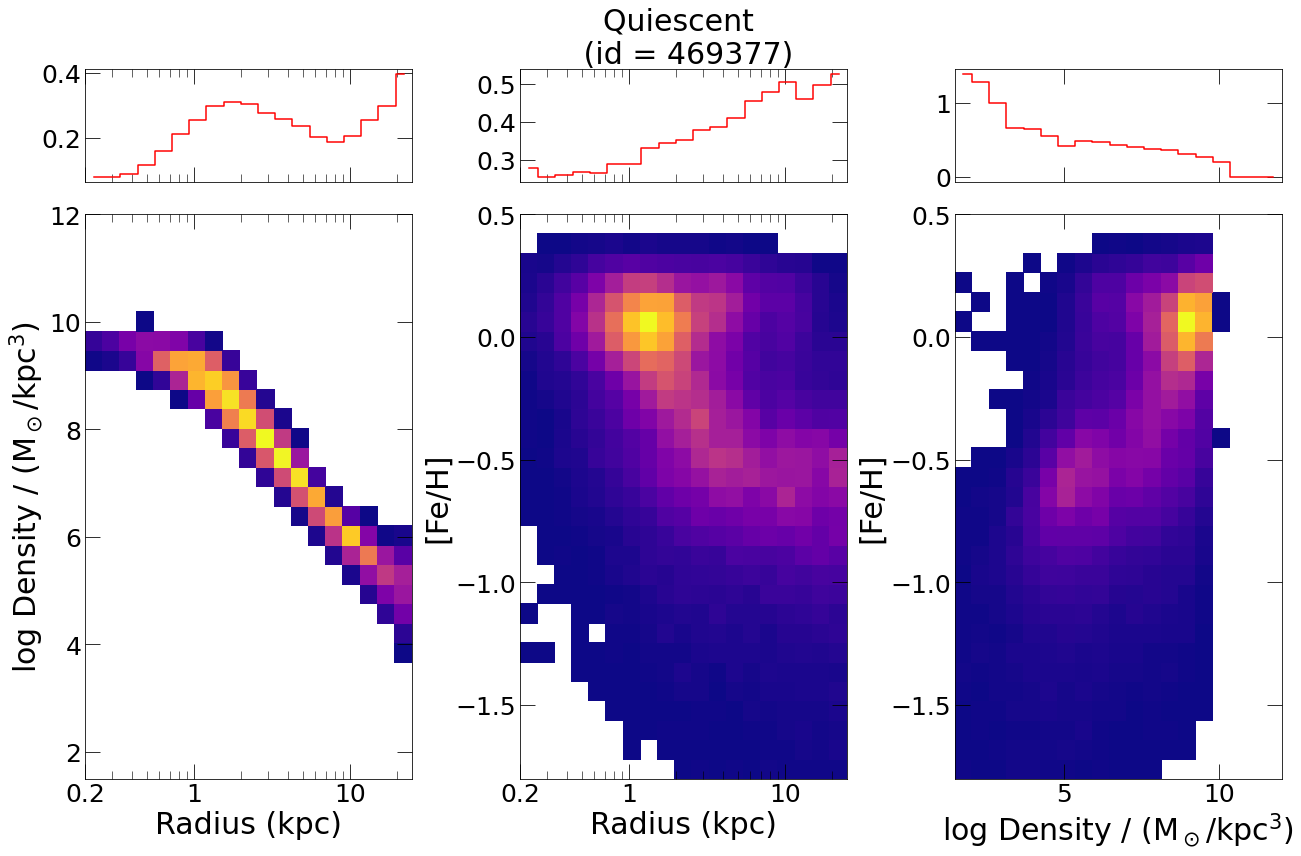

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

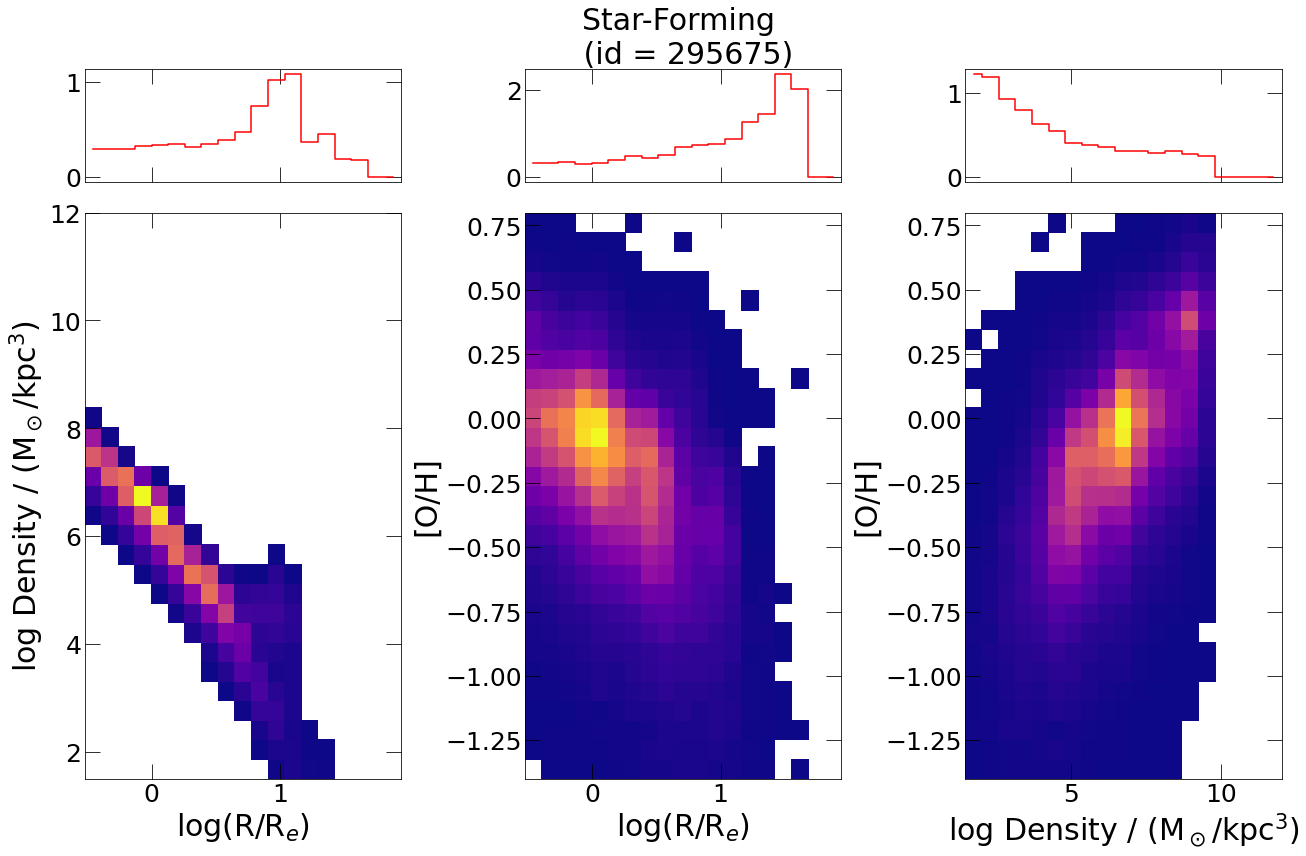

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.4, 0.8)
ax2.set_ylabel("[O/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[O/H]', fontsize=fts)
ax3.set_ylim(-1.4, 0.8)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

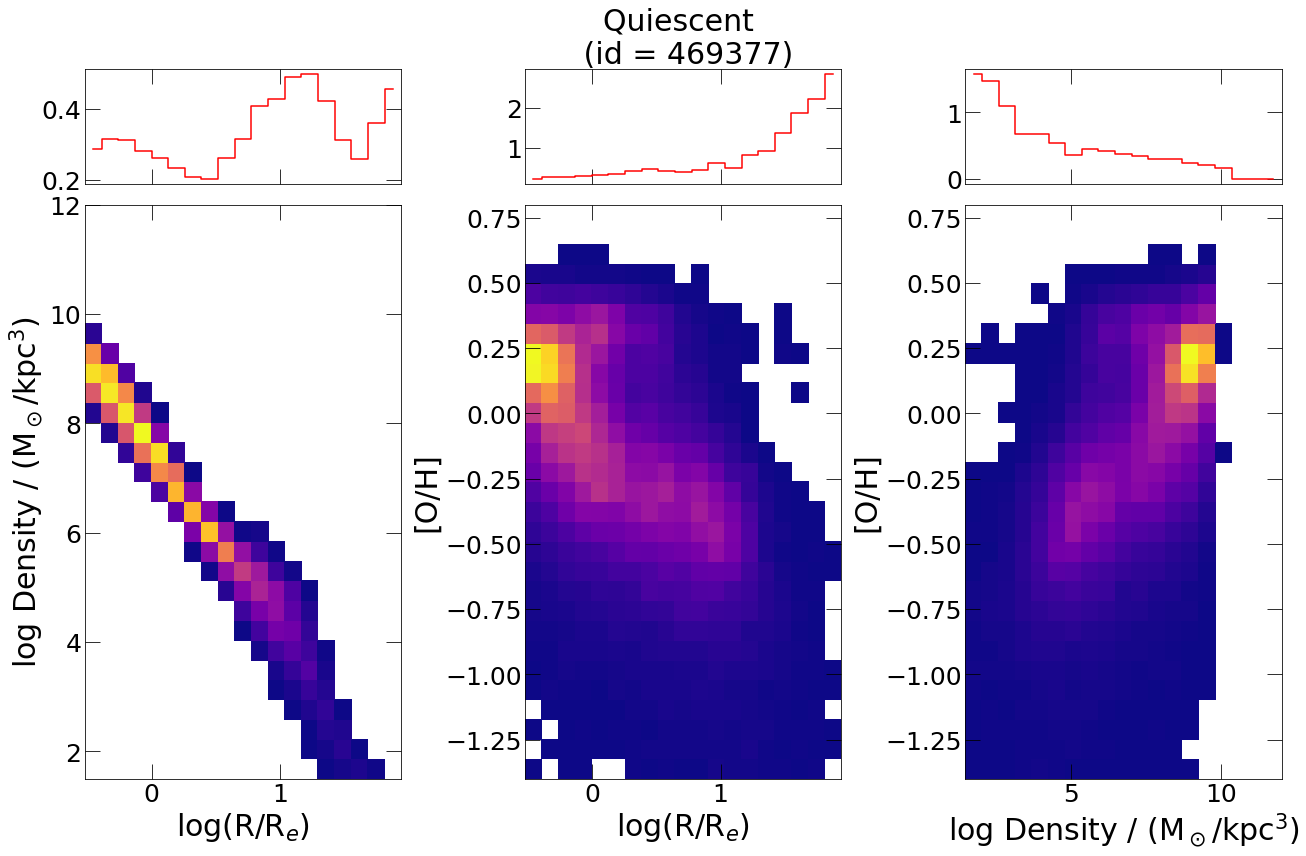

In [9]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.4, 0.8)
ax2.set_ylabel("[O/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[O/H]', fontsize=fts)
ax3.set_ylim(-1.4, 0.8)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# Gas Metallicity

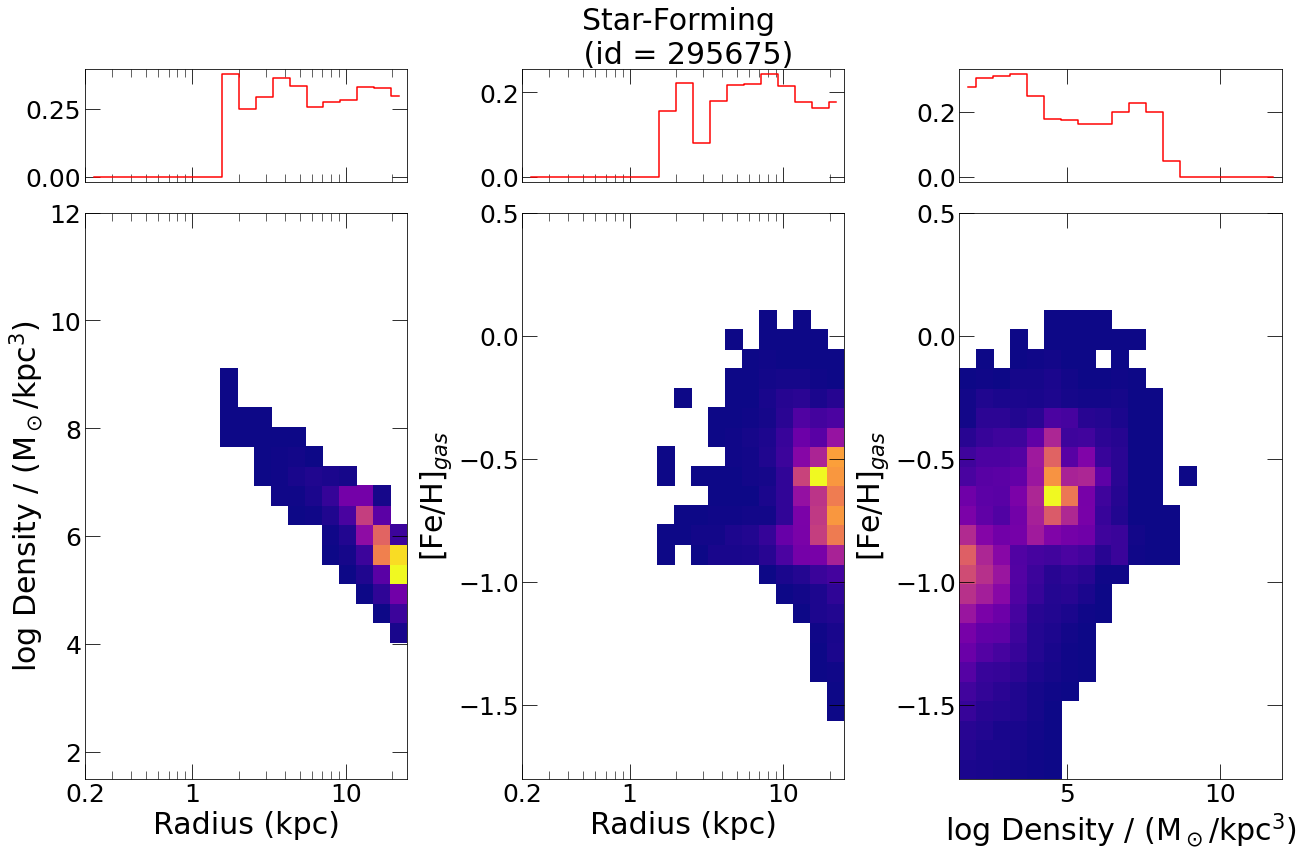

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

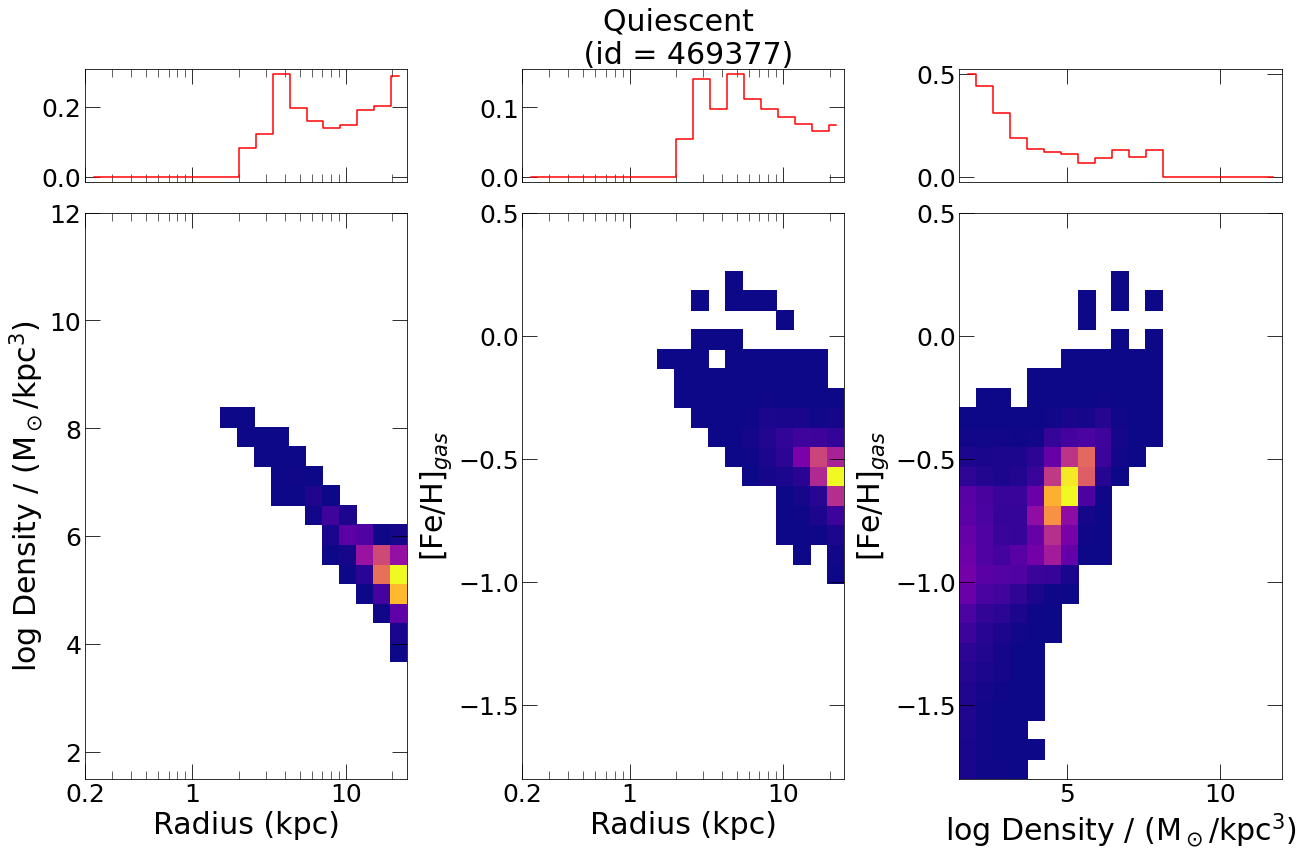

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

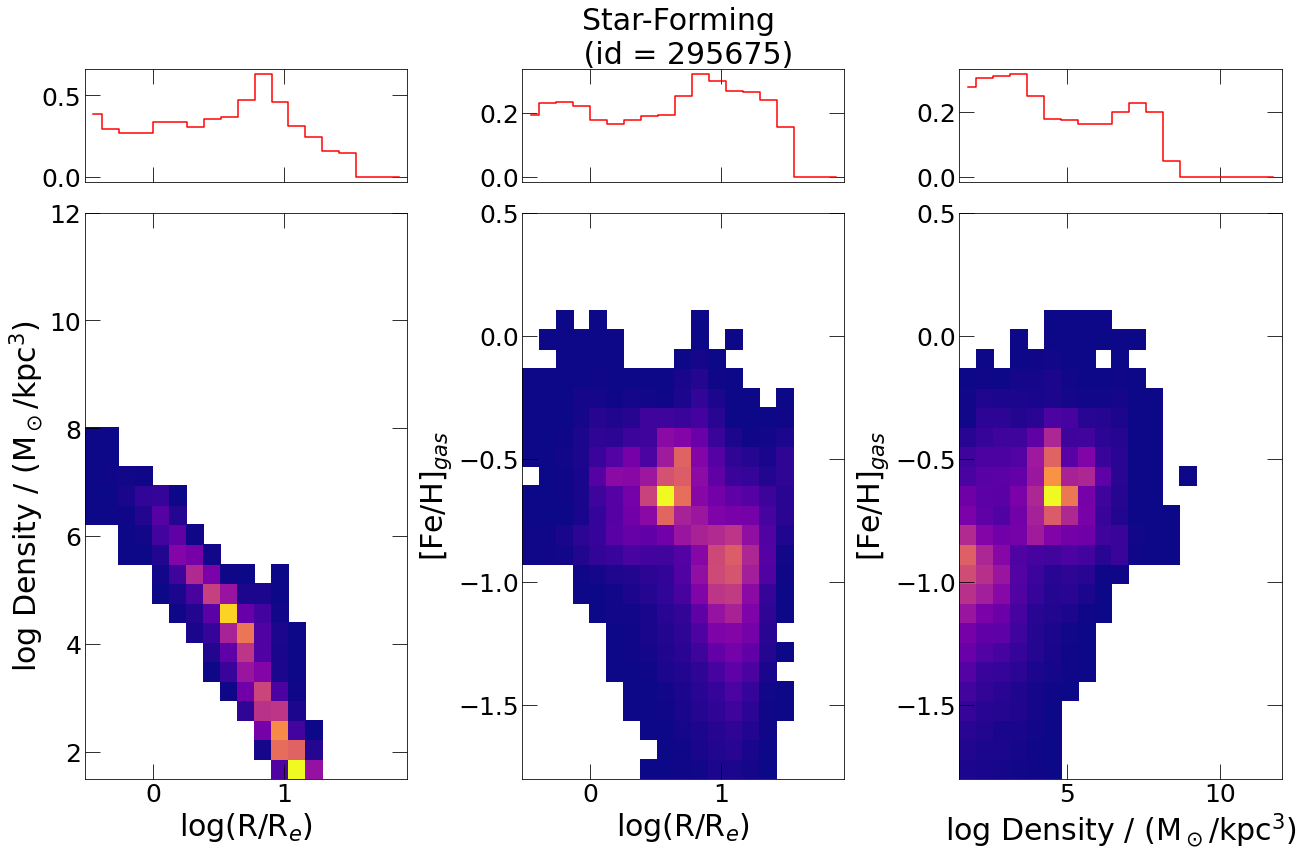

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

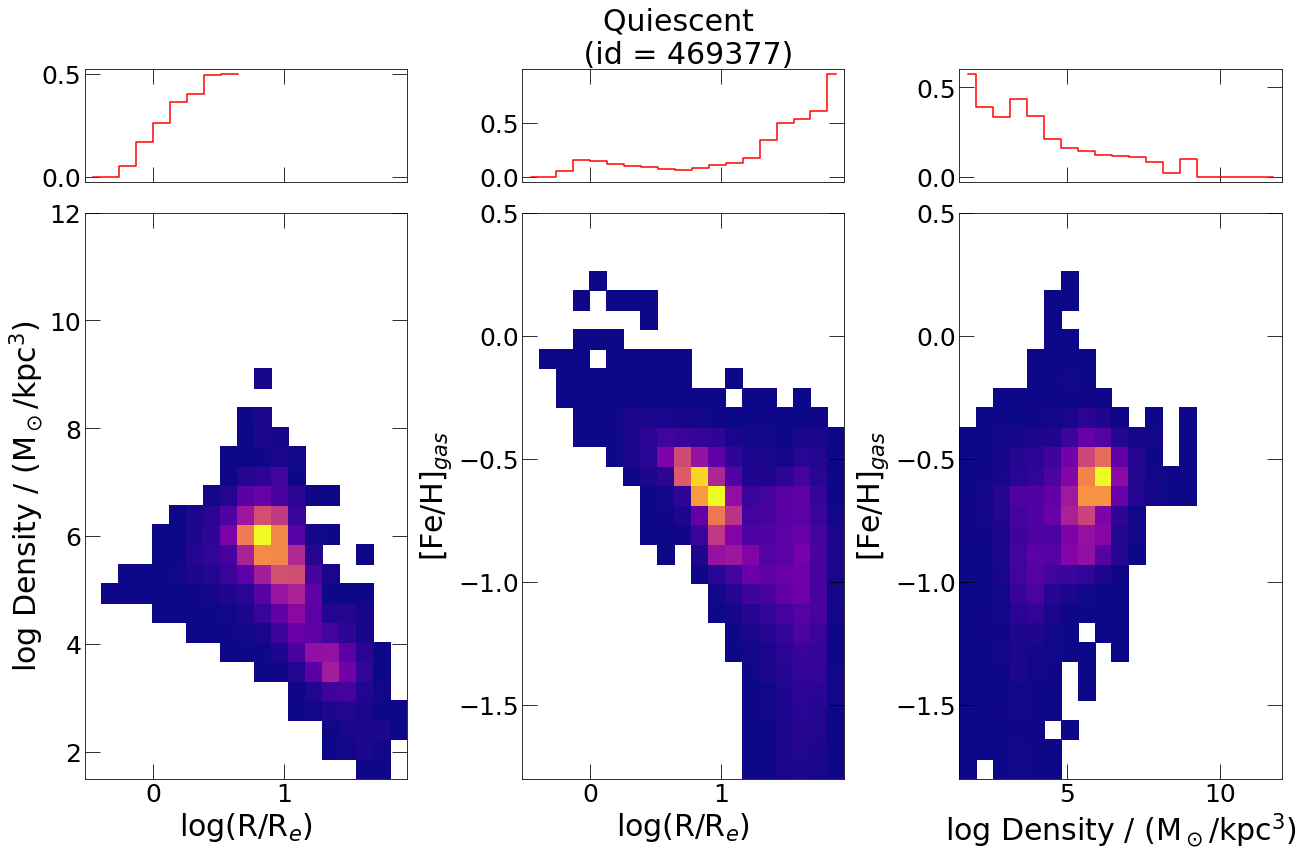

In [14]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

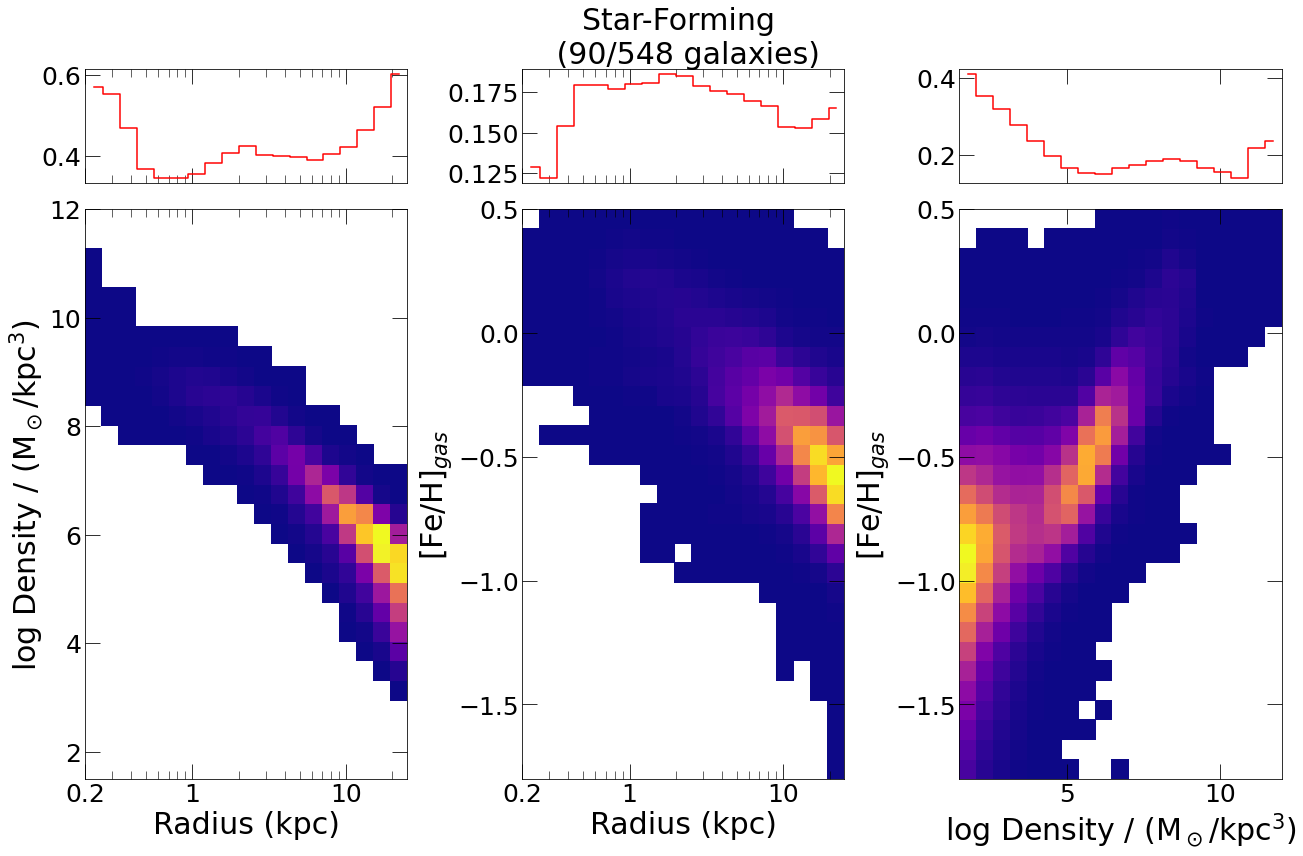

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
#     number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/'+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

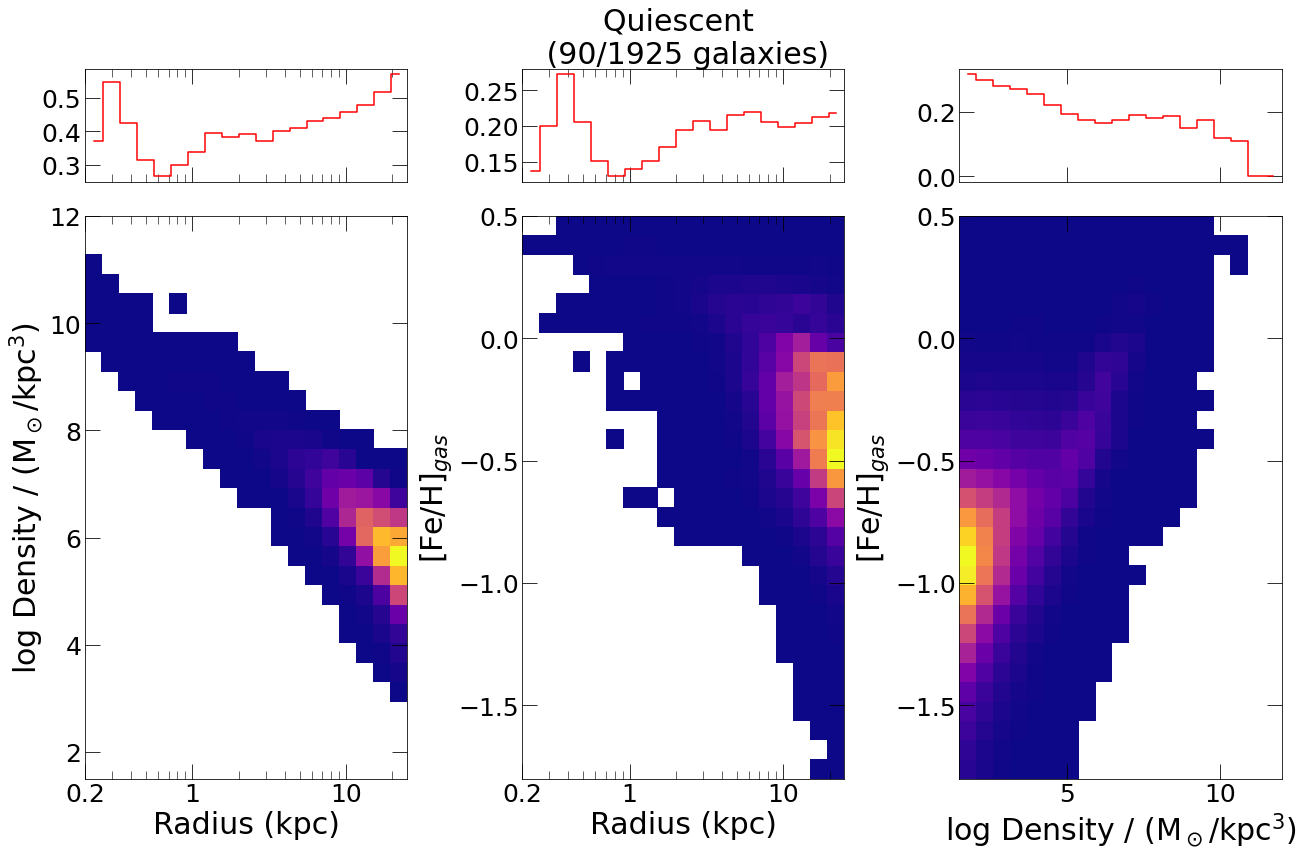

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    if type(logFeH) == int:
        pass
    else:
        big_density = np.concatenate((big_density, np.log10(density)), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
        h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
        h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
        h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
        big_h3 += h3
        big_h2 += h2
        big_h += h 
#     number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/'+str(len(ids[quiescent_selection]))+' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# y_eff

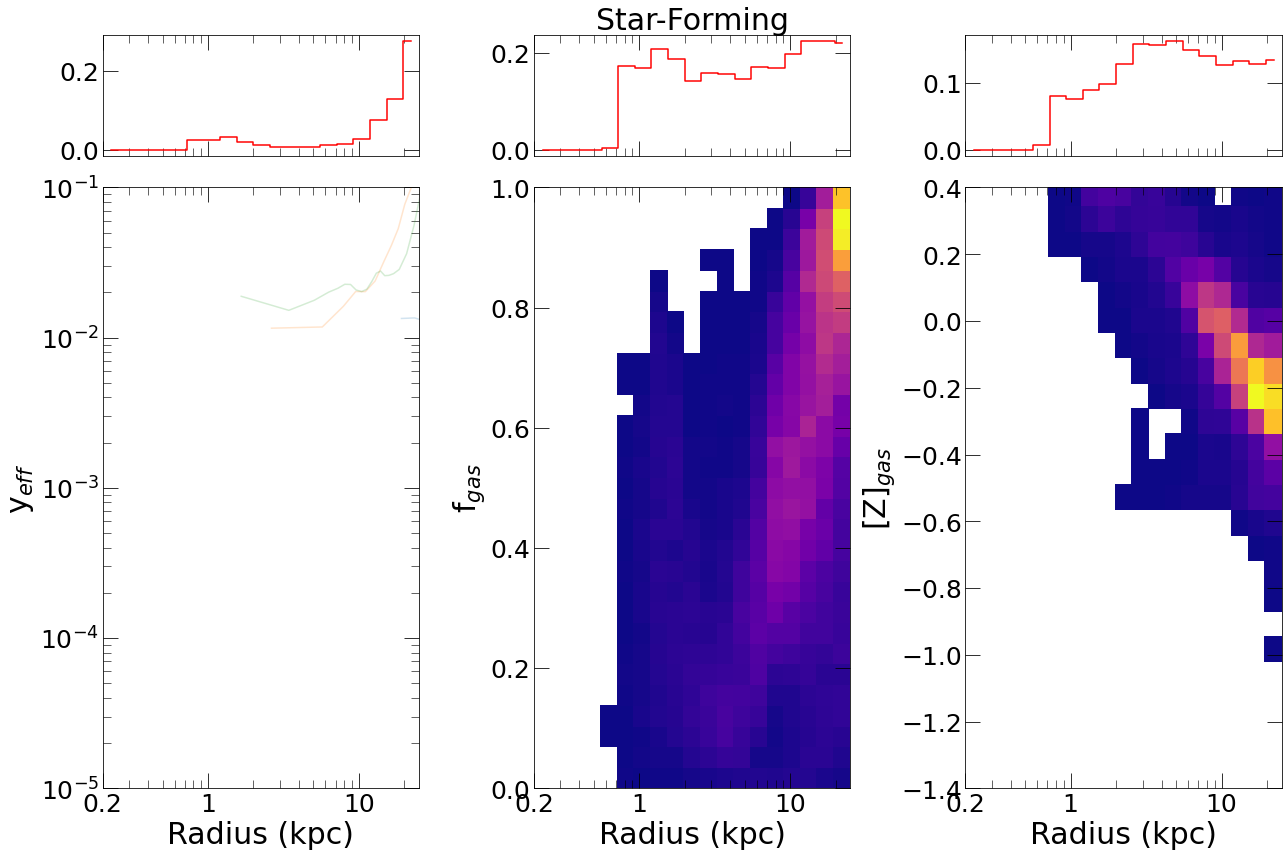

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_Z_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 3, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    Z_gas = np.log10(Z_gas / 0.0127)
    big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
    big_Z_gas = np.concatenate((big_Z_gas, Z_gas), axis=None)
    h, _, _ = np.histogram2d(R, y_eff, bins=[xbins, yeffbins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, f_gas, bins=[xbins, ybins], density=False)
    h3, _, _ = np.histogram2d(R, Z_gas, bins=[xbins, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
#     number = id
    
    # calculate statistic for profile
    n_bins = 50
    percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
    for i in range(1, (n_bins+1)):
        percentiles[i] = np.percentile(R, (100/n_bins)*i)
        
    statistic, bin_edges, bin_number = scipy.stats.binned_statistic(R, y_eff, 'median', bins=percentiles)
    xx = percentiles[:-1]
    ax1.plot(xx[1:], statistic[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_Z_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1e-5, 1e-1)
ax1.set_yscale('log')
ax1.set_ylabel("y$_{eff}$", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[Z]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.4, 0.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

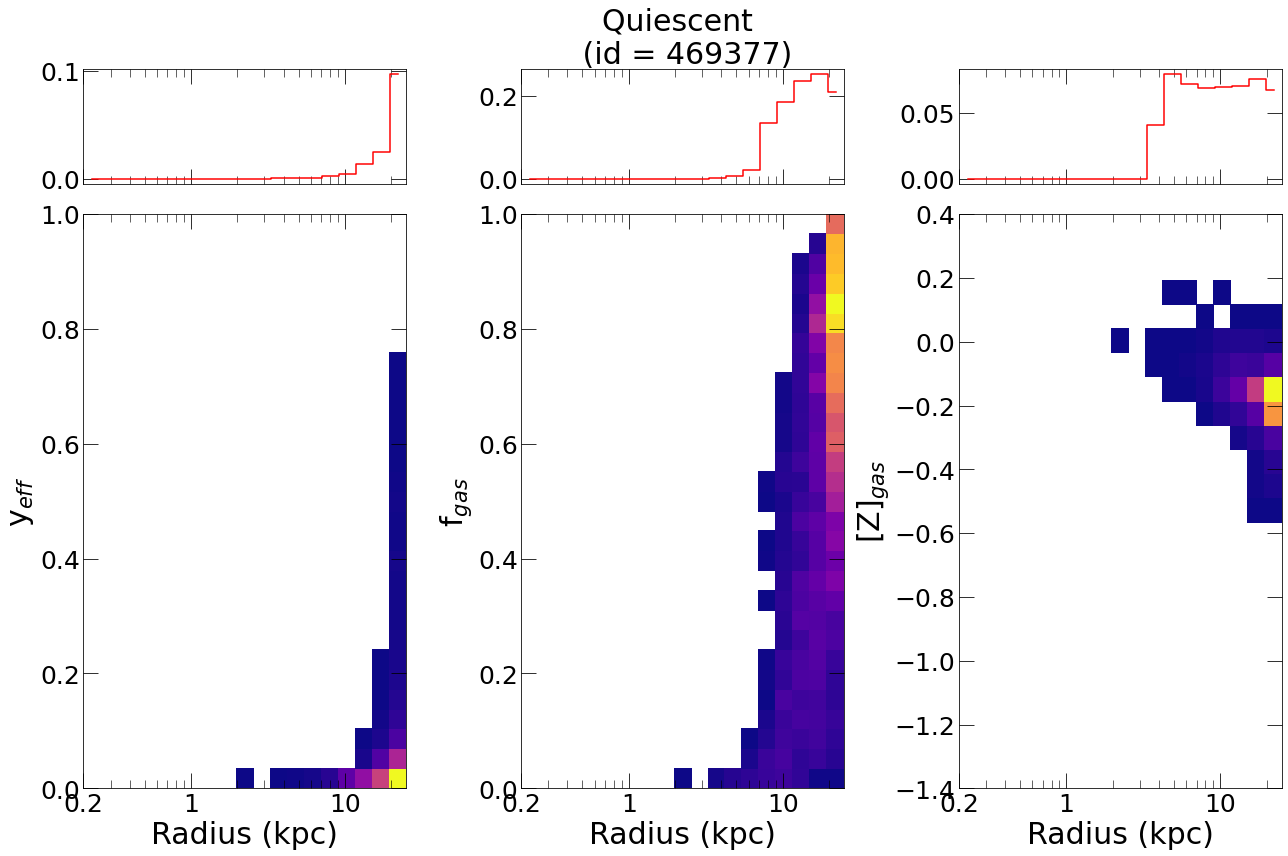

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_Z_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    Z_gas = np.log10(Z_gas / 0.0127)
    big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
    big_Z_gas = np.concatenate((big_Z_gas, Z_gas), axis=None)
    h, _, _ = np.histogram2d(R, y_eff, bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, f_gas, bins=[xbins, ybins], density=False)
    h3, _, _ = np.histogram2d(R, Z_gas, bins=[xbins, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_Z_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 1)
ax1.set_ylabel("y$_{eff}$", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[Z]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.4, 0.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

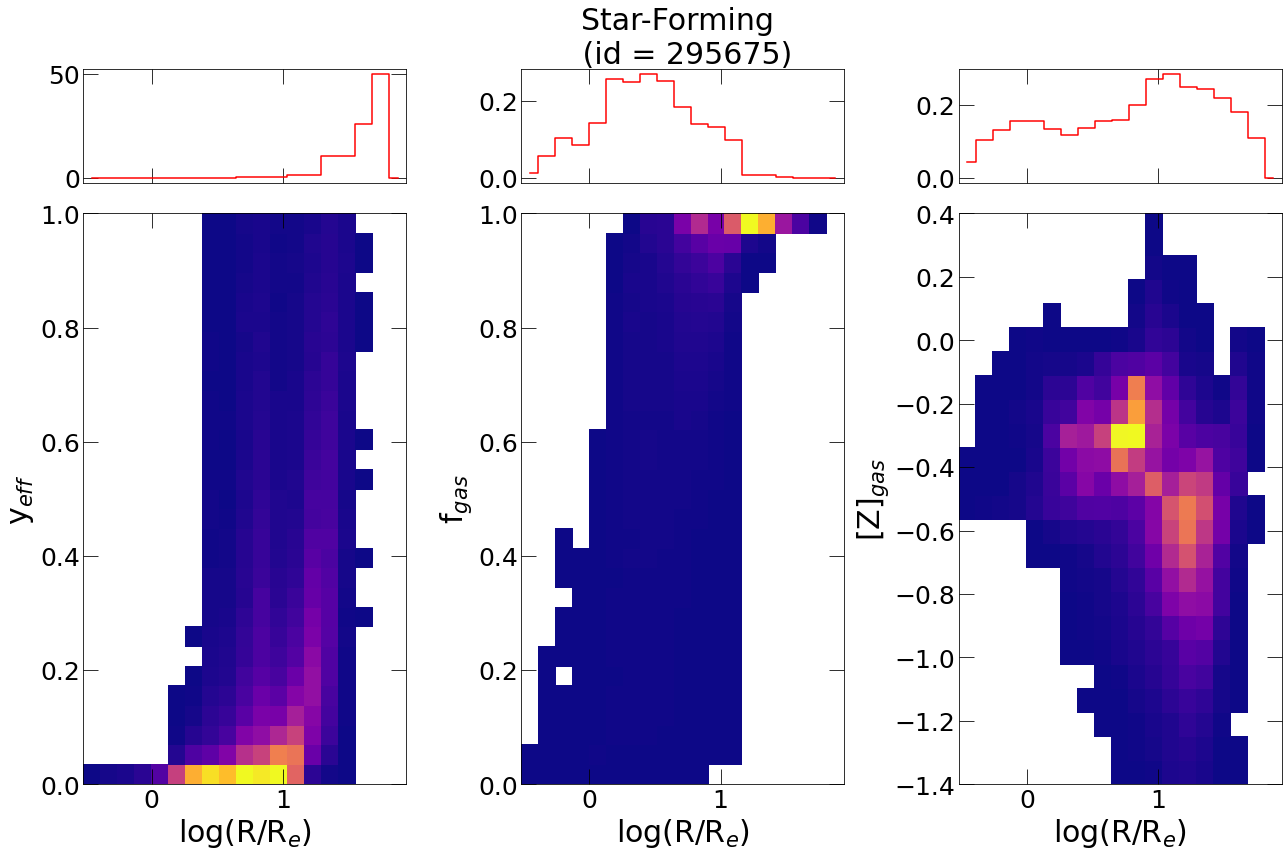

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_Z_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    R_e = halfmass_rad_stars(id, redshift)
    Z_gas = np.log10(Z_gas / 0.0127)
    big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
    big_Z_gas = np.concatenate((big_Z_gas, Z_gas), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), y_eff, bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), f_gas, bins=[xbins, ybins], density=False)
    h3, _, _ = np.histogram2d(np.log10(R/R_e), Z_gas, bins=[xbins, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_Z_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 1)
ax1.set_ylabel("y$_{eff}$", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax3.set_ylabel('[Z]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.4, 0.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

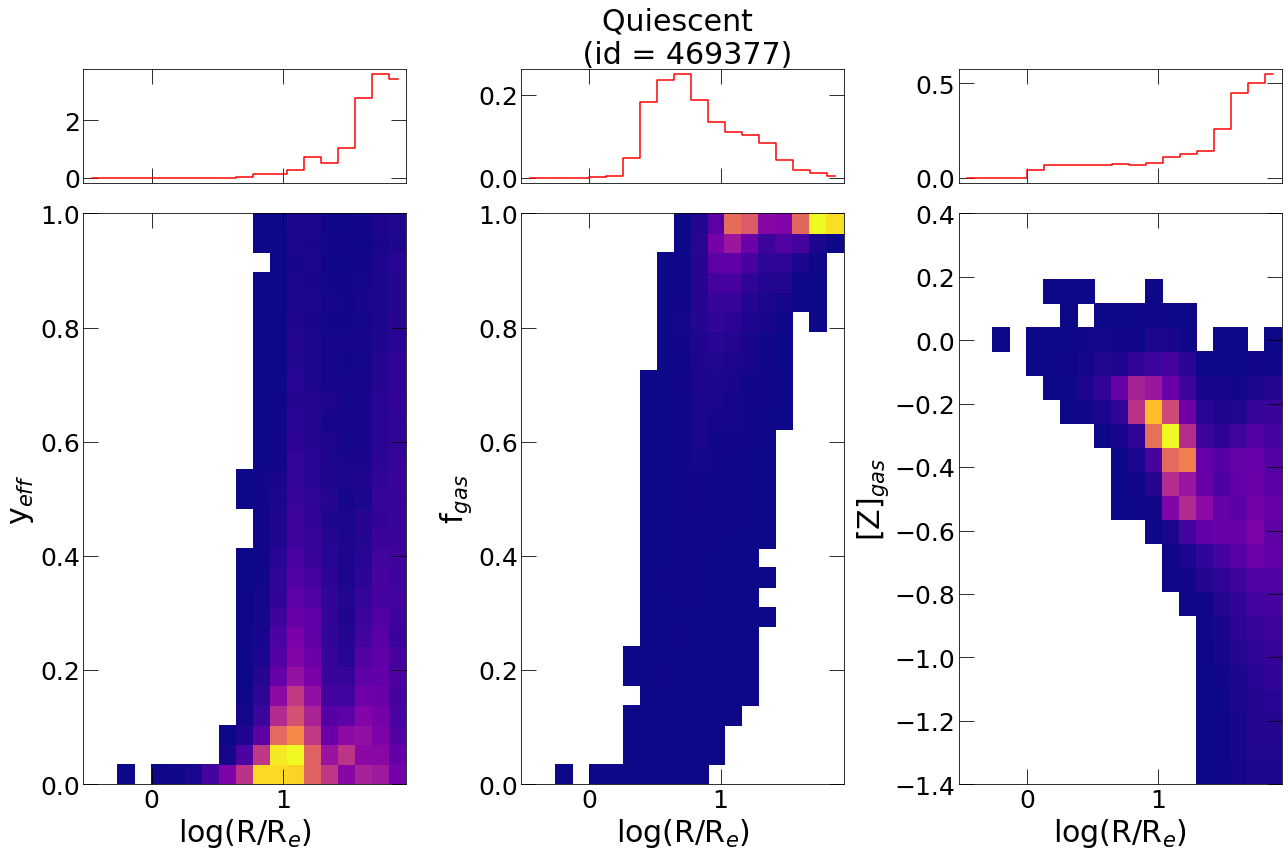

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
metalbins = np.linspace(-1.4, 0.8, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_Z_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    R_e = halfmass_rad_stars(id, redshift)
    Z_gas = np.log10(Z_gas / 0.0127)
    big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
    big_Z_gas = np.concatenate((big_Z_gas, Z_gas), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), y_eff, bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), f_gas, bins=[xbins, ybins], density=False)
    h3, _, _ = np.histogram2d(np.log10(R/R_e), Z_gas, bins=[xbins, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_Z_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 1)
ax1.set_ylabel("y$_{eff}$", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax3.set_ylabel('[Z]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.4, 0.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

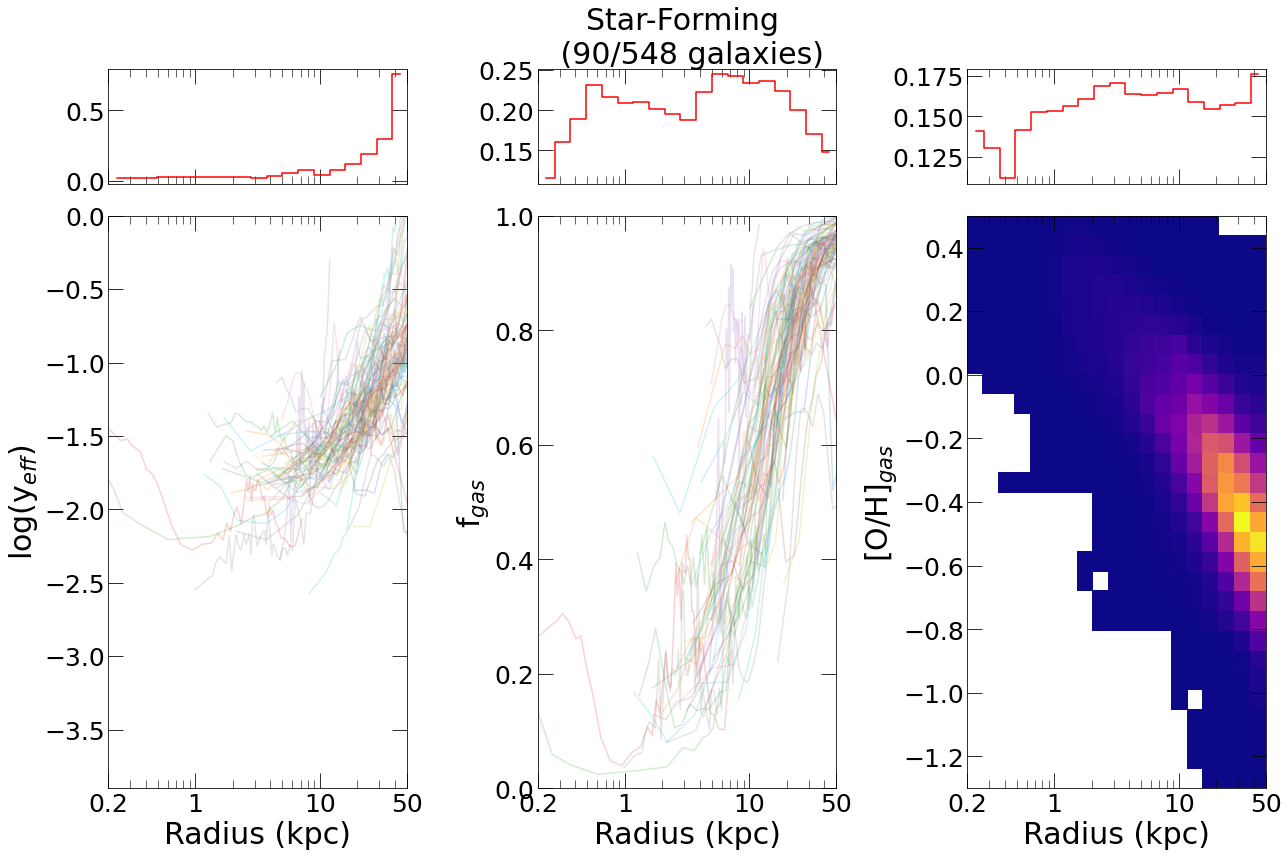

In [13]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(50), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    logOH, _, _ = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen', density=False)
#     Z_gas = np.log10(Z_gas / 0.0127)
    big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
    big_OH_gas = np.concatenate((big_OH_gas, logOH), axis=None)
#     h, _, _ = np.histogram2d(R, y_eff, bins=[xbins, yeffbins], density=False)#, len(percentiles))
#     h2, _, _ = np.histogram2d(R, f_gas, bins=[xbins, ybins], density=False)
    h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
    big_h3 += h3
#     big_h2 += h2
#     big_h += h 
#     number = id
    
    # calculate statistic for profile
    n_bins = 50
    percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
    for i in range(1, (n_bins+1)):
        percentiles[i] = np.percentile(R, (100/n_bins)*i)
        
    stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
    stat2, _, _ = scipy.stats.binned_statistic(R, f_gas, 'median', bins=percentiles)
    xx = percentiles[:-1]
    ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
    ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 35)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10', '50'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-3.9, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 35)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10', '50'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 35)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10', '50'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

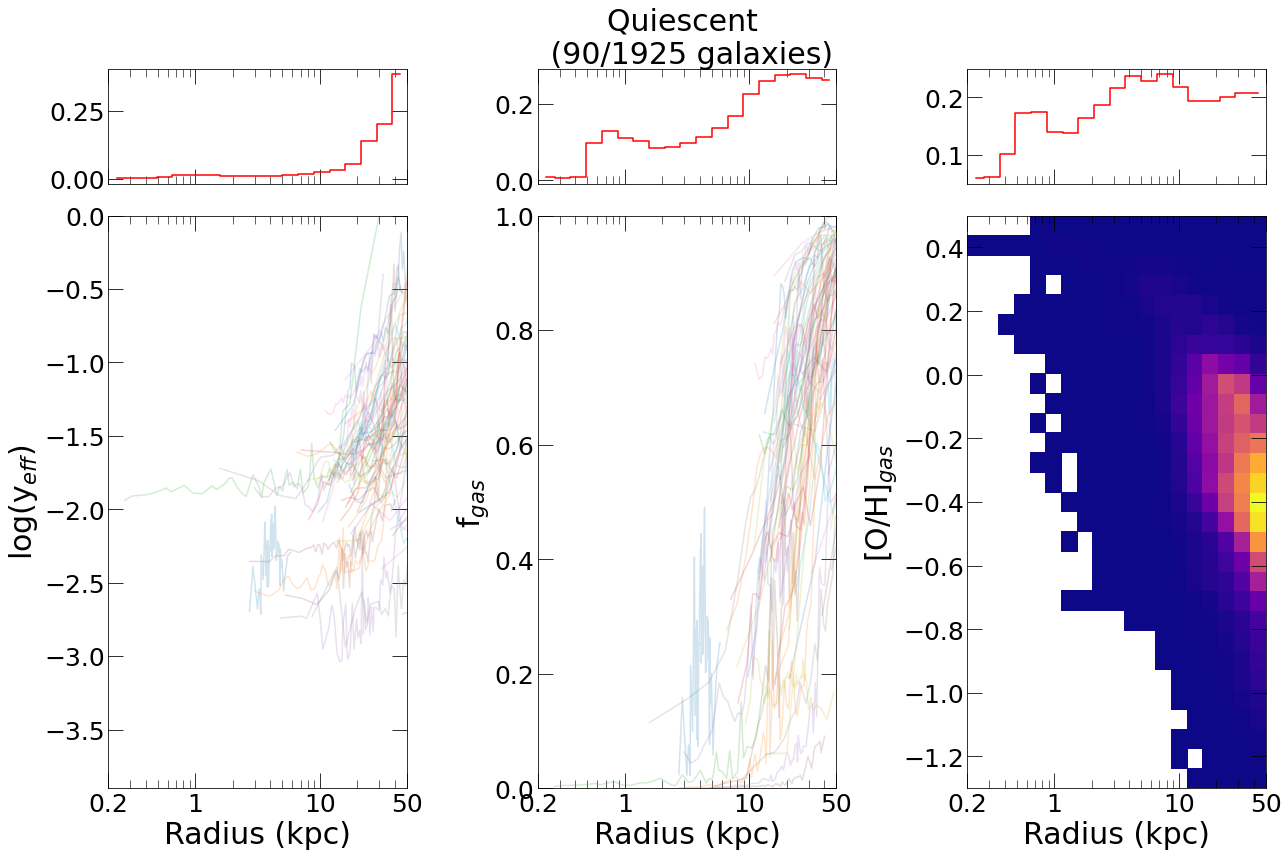

In [14]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(50), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, f_gas, y_eff, Z_gas = effective_yield(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
        logOH, _, _ = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen', density=False)
        big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, logOH), axis=None)
        h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
        big_h3 += h3

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)

        stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 50)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10', '50'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-3.9, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 50)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10', '50'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 50)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10, 50], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10', '50'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

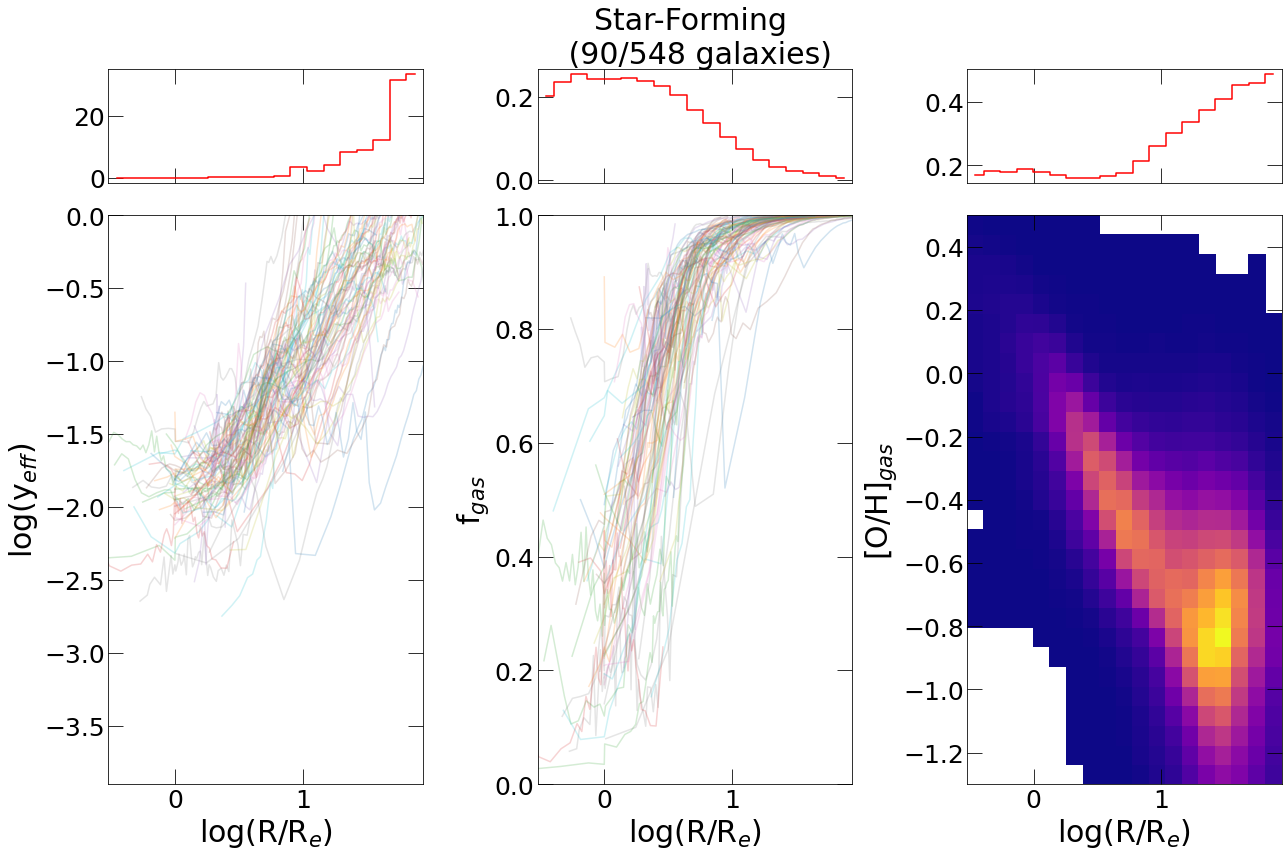

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, f_gas, y_eff, _ = effective_yield(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
        logOH = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
        big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, logOH), axis=None)
        h3, _, _ = np.histogram2d(np.log10(R/R_e), logOH, bins=[xbins, metalbins], density=False)
        big_h3 += h3

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-3.9, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

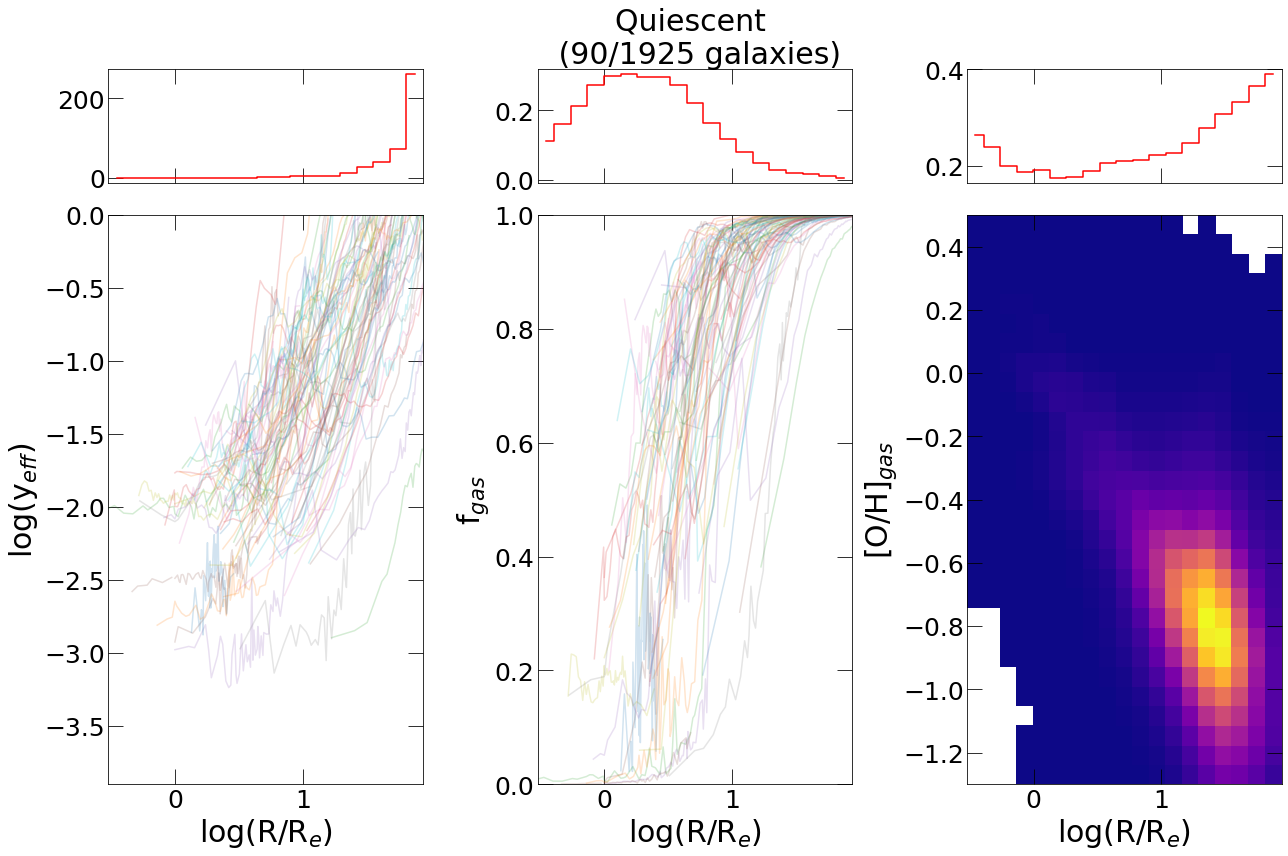

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, f_gas, y_eff, _ = effective_yield(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
        logOH = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
        big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, logOH), axis=None)
        h3, _, _ = np.histogram2d(np.log10(R/R_e), logOH, bins=[xbins, metalbins], density=False)
        big_h3 += h3

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-3.9, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(0, 1)
ax2.set_ylabel("f$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

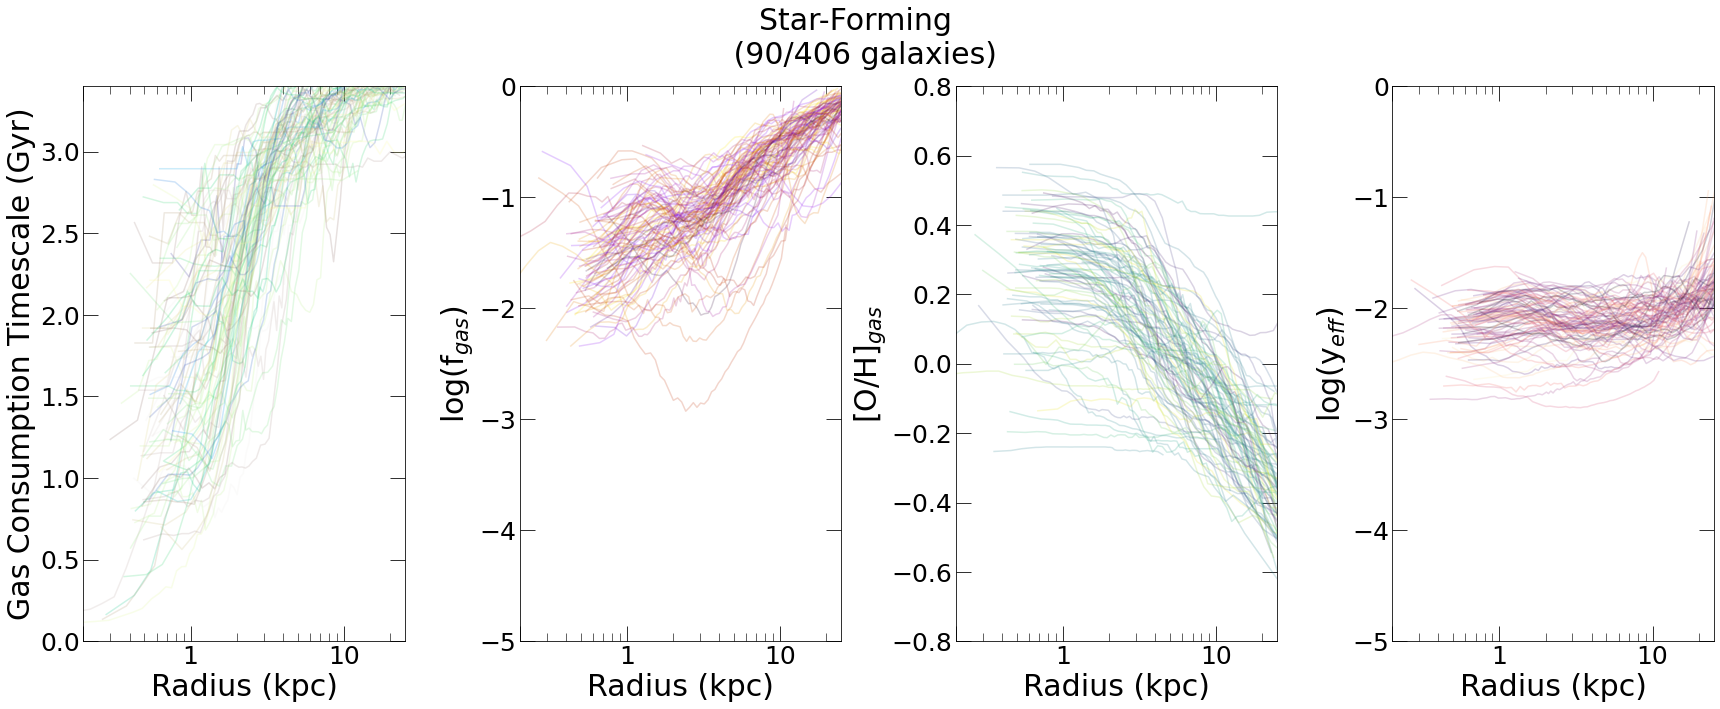

In [17]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10), constrained_layout=True)
ax3 = axes[0]
ax2 = axes[1]
ax4 = axes[2]
ax1 = axes[3]
# sc1 = axes[0][0]
# sc2 = axes[0][1]
# sc3 = axes[0][2]
# sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap3 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
colormap4 = plt.get_cmap('viridis')
colormap1 = plt.get_cmap('magma')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        gas_con, _ = gas_consumption(id=id, redshift=redshift, follow_stars=True)
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
#         R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_gas = np.concatenate((big_gas, gas_con*10**-9), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
#         big_h4 += h4

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R_star, gas_con*10**-9, 'median', bins=percentiles)
        stat4, _, _ = scipy.stats.binned_statistic(R_star, OH_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        
        
        number = randrange(30)
        color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
        color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
        color3 = colormap3(norm(number))
        color4 = colormap4(norm(number))
        ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)
        ax3.plot(xx[1:], stat3[1:], color=color3, alpha = 0.2)
        ax4.plot(xx[1:], stat4[1:], color=color4, alpha = 0.2)

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[0].set_xlim(0.2, 25)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['', '1', '10'])
#     ax[0].tick_params(which='major', length=15)
#     ax[0].tick_params(which='minor', length=8)
#     ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-5, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax.set_xlim(0.2, 25)
    ax.set_xscale('log')
    ax.set_xticks([0.2, 1, 10], minor=False)
    ax.set_xticklabels(['', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm_plasma(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0.2, 25)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('Gas Consumption Timescale (Gyr)', fontsize=fts)
ax3.set_ylim(0, 3.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

# big_h4[big_h4==0] = np.nan
# color=colormap(norm_plasma(big_h4)).tolist()
# color = tuple(color[0][:])
# ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[3].set_xlim(0.2, 25)
#     ax[3].set_xscale('log')
#     ax[3].set_xticks([0.2, 1, 10], minor=False)
#     ax[3].set_xticklabels(['', '1', '10'])
#     ax[3].tick_params(which='major', length=15)
#     ax[3].tick_params(which='minor', length=8)
#     ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 0.8)

f.suptitle('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes:
#     ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)

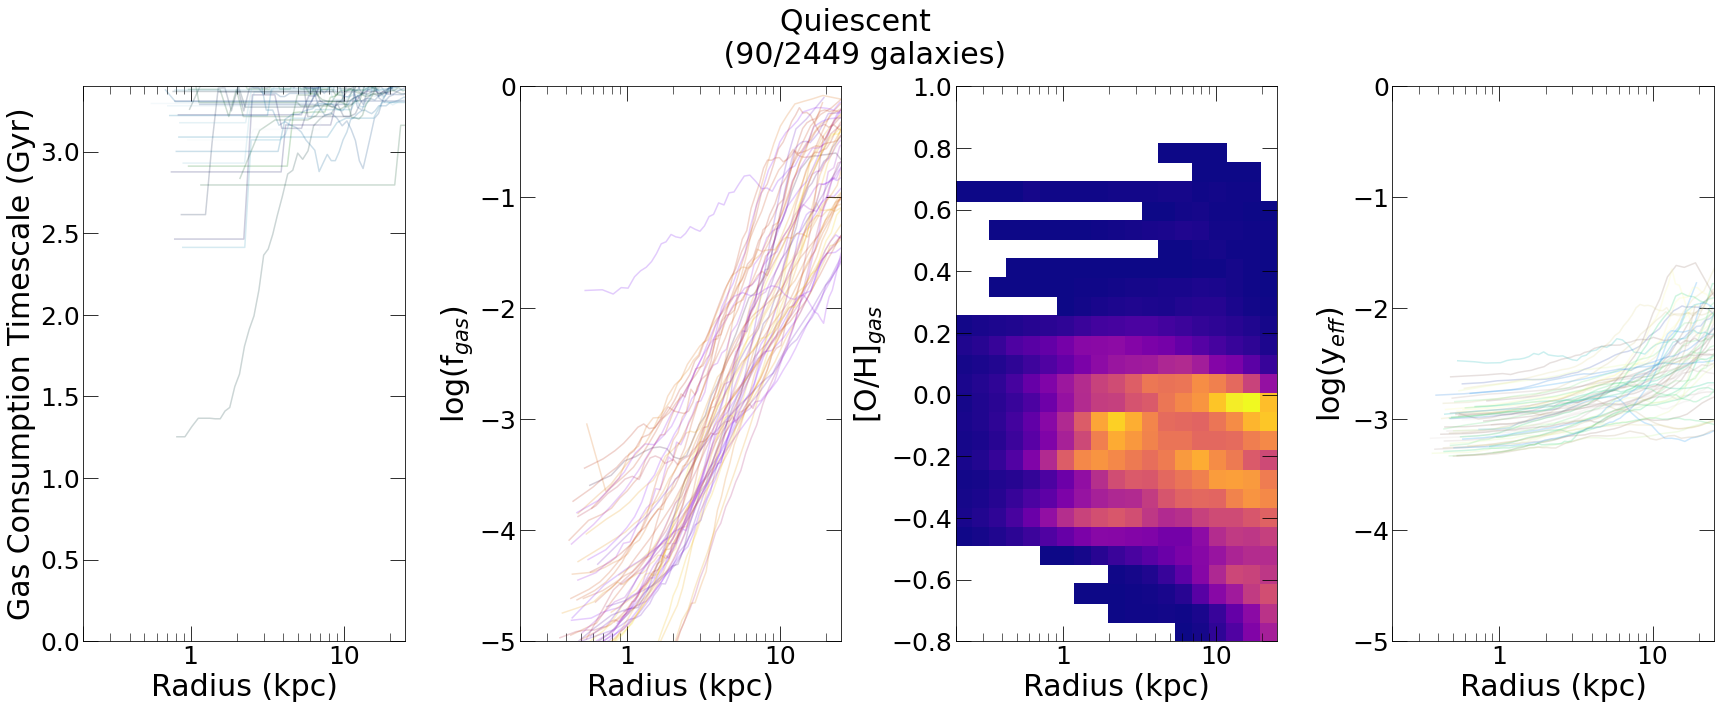

In [18]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10), constrained_layout=True)
ax3 = axes[0]
ax2 = axes[1]
ax4 = axes[2]
ax1 = axes[3]
# sc1 = axes[0][0]
# sc2 = axes[0][1]
# sc3 = axes[0][2]
# sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap1 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
colormap3 = plt.get_cmap('ocean')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
# big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
# big_f_gas = np.zeros(0)
# big_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        gas_con, _ = gas_consumption(id=id, redshift=redshift, follow_stars=True)
        if type(gas_con) == int:
            pass
        else:
            OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
    #         R_e = halfmass_rad_stars(id, redshift)
    #         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
            big_R = np.concatenate((big_R, R), axis=None)
            big_R_star = np.concatenate((big_R_star, R_star), axis=None)
    #         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
    #         big_gas = np.concatenate((big_gas, gas_con*10**-9), axis=None)
            big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
            h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
            big_h4 += h4

            # calculate statistic for profile
            n_bins = 50
            percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
            for i in range(1, (n_bins+1)):
                percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
            percentiles.sort()
            stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
            stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
            stat3, _, _ = scipy.stats.binned_statistic(R_star, gas_con*10**-9, 'median', bins=percentiles)
            xx = percentiles[:-1]


            number = randrange(30)
            color1 = colormap1(norm(number))
    #         color1 = tuple(color1[0][:])
            color2 = colormap2(norm(number))
    #         color2 = tuple(color2[0][:])
            color3 = colormap3(norm(number))
            ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
            ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)
            ax3.plot(xx[3:], stat3[3:], color=color3, alpha = 0.2)

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[0].set_xlim(0.2, 25)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['', '1', '10'])
#     ax[0].tick_params(which='major', length=15)
#     ax[0].tick_params(which='minor', length=8)
#     ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-5, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax.set_xlim(0.2, 25)
    ax.set_xscale('log')
    ax.set_xticks([0.2, 1, 10], minor=False)
    ax.set_xticklabels(['', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm_plasma(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0.2, 25)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('Gas Consumption Timescale (Gyr)', fontsize=fts)
ax3.set_ylim(0, 3.4)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

big_h4[big_h4==0] = np.nan
color=colormap(norm_plasma(big_h4)).tolist()
color = tuple(color[0][:])
ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[3].set_xlim(0.2, 25)
#     ax[3].set_xscale('log')
#     ax[3].set_xticks([0.2, 1, 10], minor=False)
#     ax[3].set_xticklabels(['', '1', '10'])
#     ax[3].tick_params(which='major', length=15)
#     ax[3].tick_params(which='minor', length=8)
#     ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 1)

f.suptitle('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes:
#     ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff_quiescent.png', dpi=100)

## density comparison

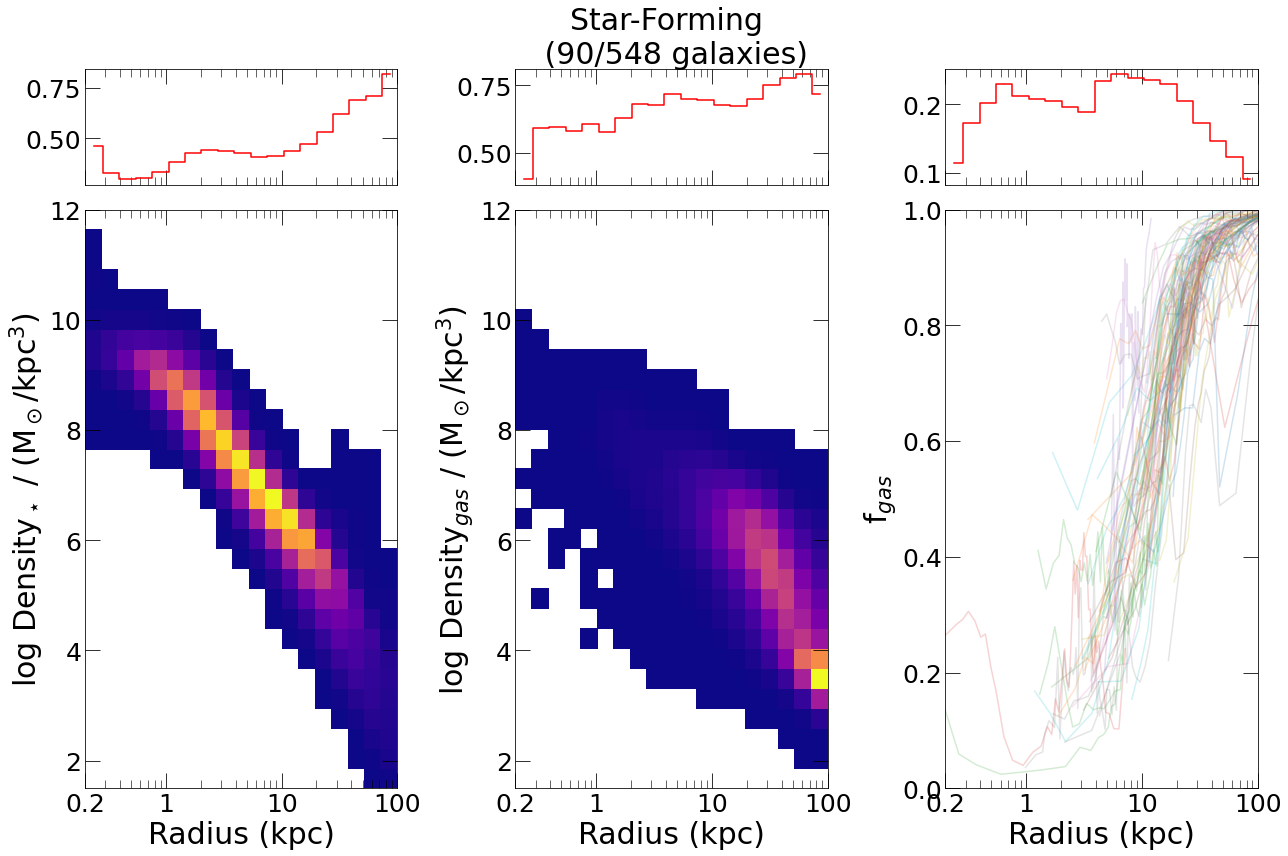

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(100), 20)
densitybins = np.linspace(1.5, 12, 30)
fgasbins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-1.3, 0.5, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(densitybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(densitybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(fgasbins)-1))
big_rho_star = np.zeros(0)
big_R_gas = np.zeros(0)
big_f_gas = np.zeros(0)
big_rho_gas = np.zeros(0)
big_R_star = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R_gas, f_gas, _, _ = effective_yield(id=id, redshift=redshift)
    if type(R_gas) == int:
        pass
    else:
        R_star, _, rho_star, rho_gas = stellar_gas_densities(id=id, redshift=redshift, follow_stars=False)
    #     Z_gas = np.log10(Z_gas / 0.0127)
        big_rho_star = np.concatenate((big_rho_star, np.log10(rho_star)), axis=None)
        big_rho_gas = np.concatenate((big_rho_gas, np.log10(rho_gas)), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_R_gas = np.concatenate((big_R_gas, R_gas), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        h, _, _ = np.histogram2d(R_star, np.log10(rho_star), bins=[xbins, densitybins], density=False)#, len(percentiles))
        h2, _, _ = np.histogram2d(R_gas, np.log10(rho_gas), bins=[xbins, densitybins], density=False)
#         h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
        big_h2 += h2
        big_h += h 
    #     number = id
    
        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_gas, (100/n_bins)*i)

    #     stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R_gas, f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax3.plot(xx[1:], stat3[1:], alpha = 0.2)
#     ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_rho_star, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_gas, big_rho_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_gas, big_f_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, densitybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 100)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10', '100'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
# ax1.set_yscale('log')
ax1.set_xlabel("Radius (kpc)", fontsize=fts)
ax1.set_ylabel('log Density$_\star$ / (M$_\odot$/kpc$^3$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, densitybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 100)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10', '100'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(1.5, 12)
ax2.set_ylabel('log Density$_{gas}$ / (M$_\odot$/kpc$^3$)', fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 100)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10', '100'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('f$_{gas}$', fontsize=fts)
ax3.set_ylim(0, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

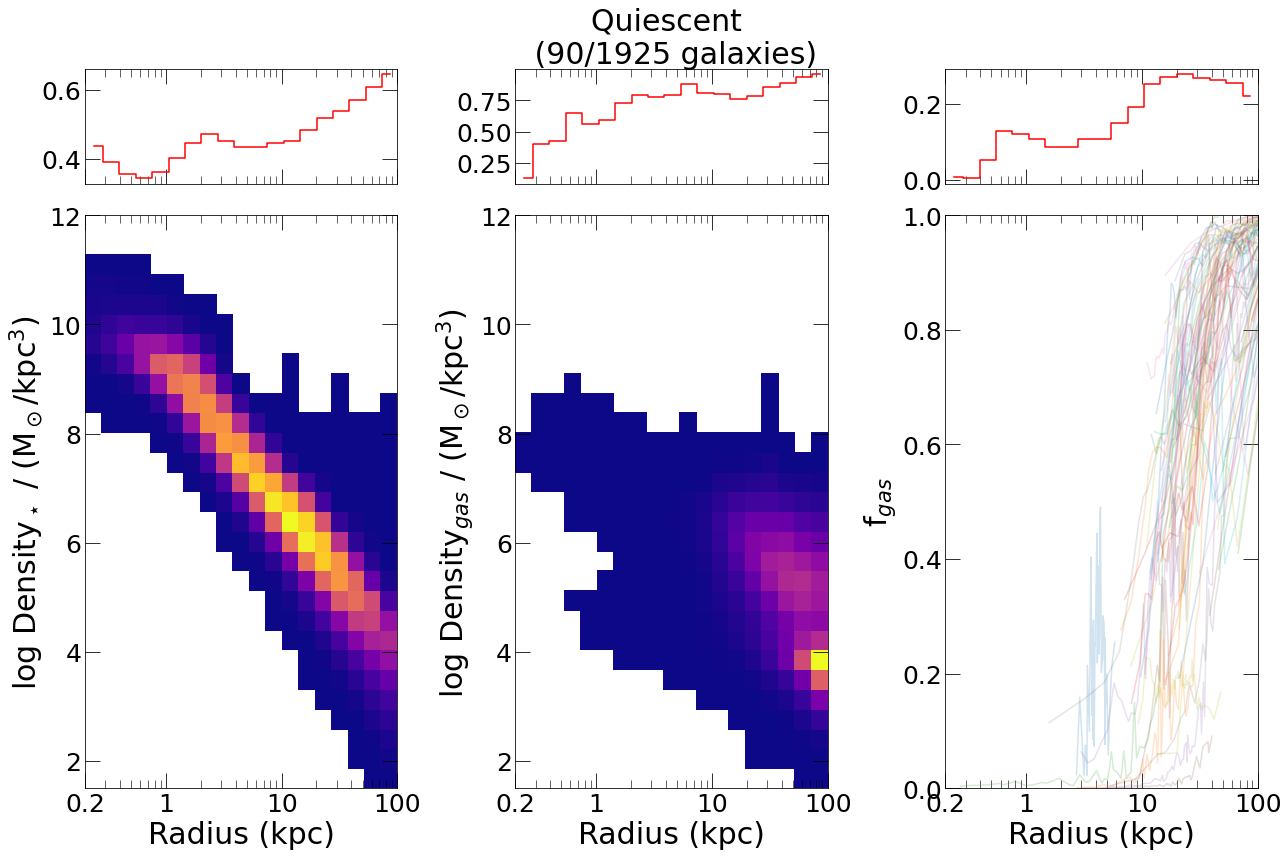

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(100), 20)
densitybins = np.linspace(1.5, 12, 30)
fgasbins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-1.3, 0.5, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(densitybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(densitybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(fgasbins)-1))
big_rho_star = np.zeros(0)
big_R_gas = np.zeros(0)
big_f_gas = np.zeros(0)
big_rho_gas = np.zeros(0)
big_R_star = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R_gas, f_gas, _, _ = effective_yield(id=id, redshift=redshift)
    if type(R_gas) == int:
        pass
    else:
        R_star, _, rho_star, rho_gas = stellar_gas_densities(id=id, redshift=redshift, follow_stars=False)
    #     Z_gas = np.log10(Z_gas / 0.0127)
        big_rho_star = np.concatenate((big_rho_star, np.log10(rho_star)), axis=None)
        big_rho_gas = np.concatenate((big_rho_gas, np.log10(rho_gas)), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_R_gas = np.concatenate((big_R_gas, R_gas), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        h, _, _ = np.histogram2d(R_star, np.log10(rho_star), bins=[xbins, densitybins], density=False)#, len(percentiles))
        h2, _, _ = np.histogram2d(R_gas, np.log10(rho_gas), bins=[xbins, densitybins], density=False)
#         h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
        big_h2 += h2
        big_h += h 
    #     number = id
    
        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_gas, (100/n_bins)*i)

    #     stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R_gas, f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax3.plot(xx[1:], stat3[1:], alpha = 0.2)
    #     ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_rho_star, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_gas, big_rho_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_gas, big_f_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, densitybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 100)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10', '100'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
# ax1.set_yscale('log')
ax1.set_xlabel("Radius (kpc)", fontsize=fts)
ax1.set_ylabel('log Density$_\star$ / (M$_\odot$/kpc$^3$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, densitybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 100)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10', '100'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(1.5, 12)
ax2.set_ylabel('log Density$_{gas}$ / (M$_\odot$/kpc$^3$)', fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 100)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10, 100], minor=False)
    ax[2].set_xticklabels(['0.2', '1', '10', '100'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('f$_{gas}$', fontsize=fts)
ax3.set_ylim(0, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

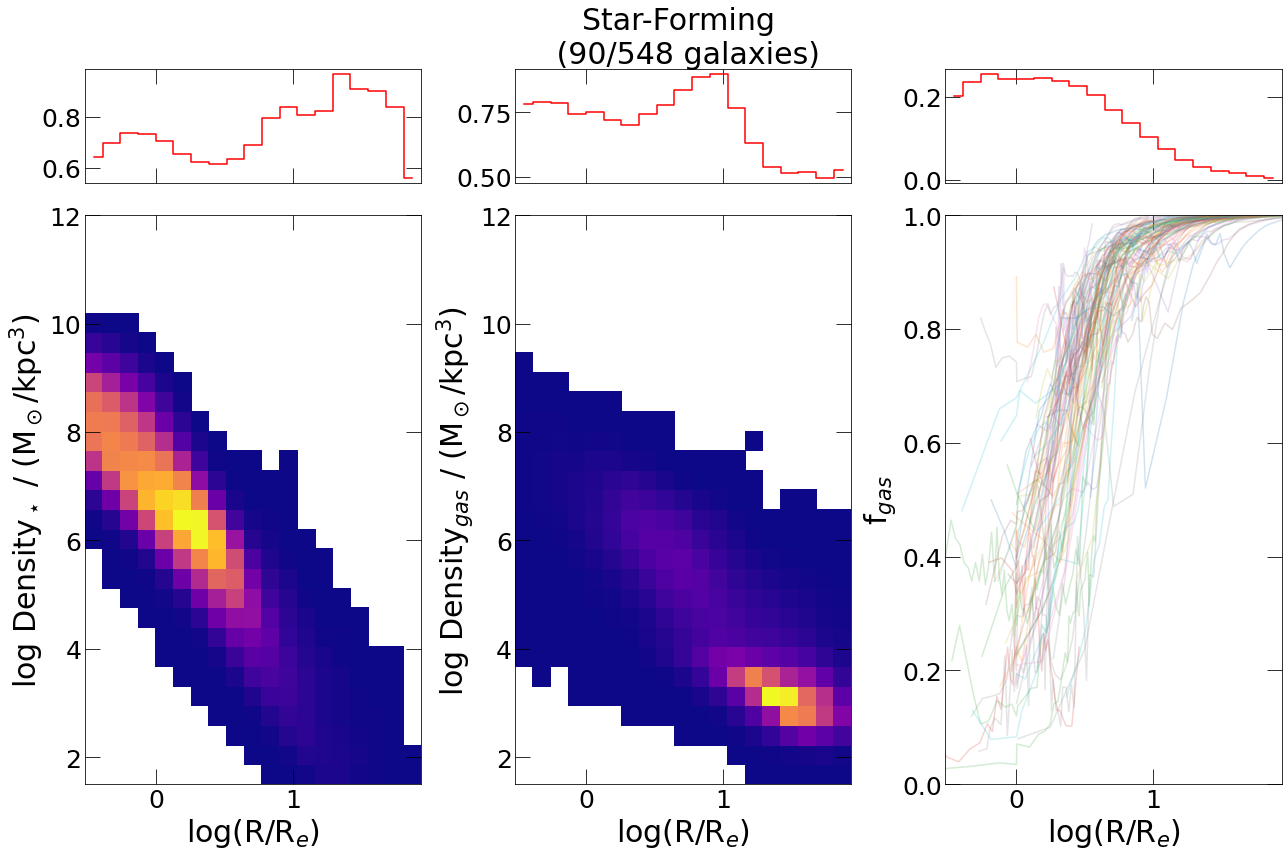

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(100), 20)
densitybins = np.linspace(1.5, 12, 30)
fgasbins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-1.3, 0.5, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(densitybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(densitybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(fgasbins)-1))
big_rho_star = np.zeros(0)
big_R_gas = np.zeros(0)
big_f_gas = np.zeros(0)
big_rho_gas = np.zeros(0)
big_R_star = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R_gas, f_gas, _, _ = effective_yield(id=id, redshift=redshift)
    if type(R_gas) == int:
        pass
    else:
        R_e = halfmass_rad_stars(id, redshift)
        R_star, _, rho_star, rho_gas = stellar_gas_densities(id=id, redshift=redshift, follow_stars=False)
    #     Z_gas = np.log10(Z_gas / 0.0127)
        big_rho_star = np.concatenate((big_rho_star, np.log10(rho_star)), axis=None)
        big_rho_gas = np.concatenate((big_rho_gas, np.log10(rho_gas)), axis=None)
        big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
        big_R_gas = np.concatenate((big_R_gas, np.log10(R_gas/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        h, _, _ = np.histogram2d(np.log10(R_star/R_e), np.log10(rho_star), bins=[xbins, densitybins], density=False)#, len(percentiles))
        h2, _, _ = np.histogram2d(np.log10(R_gas/R_e), np.log10(rho_gas), bins=[xbins, densitybins], density=False)
#         h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
        big_h2 += h2
        big_h += h 
    #     number = id
    
        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R_gas/R_e), (100/n_bins)*i)
        percentiles.sort()

    #     stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(np.log10(R_gas/R_e), f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax3.plot(xx[1:], stat3[1:], alpha = 0.2)
#     ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_rho_star, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_gas, big_rho_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_gas, big_f_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, densitybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10', '100'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
# ax1.set_yscale('log')
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax1.set_ylabel('log Density$_\star$ / (M$_\odot$/kpc$^3$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, densitybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10', '100'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(1.5, 12)
ax2.set_ylabel('log Density$_{gas}$ / (M$_\odot$/kpc$^3$)', fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10', '100'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax3.set_ylabel('f$_{gas}$', fontsize=fts)
ax3.set_ylim(0, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

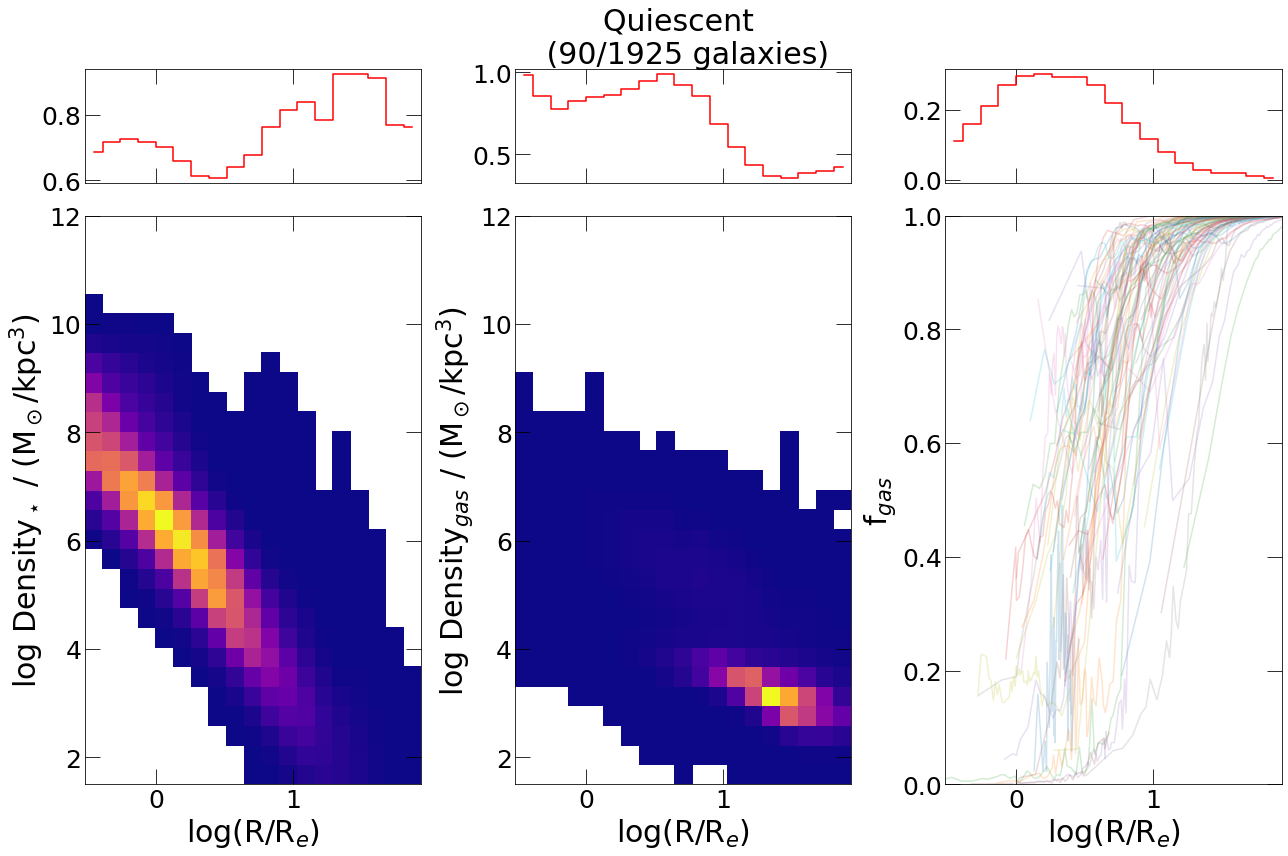

In [9]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(100), 20)
densitybins = np.linspace(1.5, 12, 30)
fgasbins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-1.3, 0.5, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(densitybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(densitybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(fgasbins)-1))
big_rho_star = np.zeros(0)
big_R_gas = np.zeros(0)
big_f_gas = np.zeros(0)
big_rho_gas = np.zeros(0)
big_R_star = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R_gas, f_gas, _, _ = effective_yield(id=id, redshift=redshift)
    if type(R_gas) == int:
        pass
    else:
        R_e = halfmass_rad_stars(id, redshift)
        R_star, _, rho_star, rho_gas = stellar_gas_densities(id=id, redshift=redshift, follow_stars=False)
    #     Z_gas = np.log10(Z_gas / 0.0127)
        big_rho_star = np.concatenate((big_rho_star, np.log10(rho_star)), axis=None)
        big_rho_gas = np.concatenate((big_rho_gas, np.log10(rho_gas)), axis=None)
        big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
        big_R_gas = np.concatenate((big_R_gas, np.log10(R_gas/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, f_gas), axis=None)
        h, _, _ = np.histogram2d(np.log10(R_star/R_e), np.log10(rho_star), bins=[xbins, densitybins], density=False)#, len(percentiles))
        h2, _, _ = np.histogram2d(np.log10(R_gas/R_e), np.log10(rho_gas), bins=[xbins, densitybins], density=False)
#         h3, _, _ = np.histogram2d(R, logOH, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
        big_h2 += h2
        big_h += h 
    #     number = id
    
        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R_gas/R_e), (100/n_bins)*i)
        percentiles.sort()

    #     stat1, _, _ = scipy.stats.binned_statistic(R, np.log10(y_eff), 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(np.log10(R_gas/R_e), f_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax3.plot(xx[1:], stat3[1:], alpha = 0.2)
    #     ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_rho_star, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_gas, big_rho_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_gas, big_f_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, densitybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10', '100'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
# ax1.set_yscale('log')
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax1.set_ylabel('log Density$_\star$ / (M$_\odot$/kpc$^3$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, densitybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10', '100'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(1.5, 12)
ax2.set_ylabel('log Density$_{gas}$ / (M$_\odot$/kpc$^3$)', fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-0.52, 1.94)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10, 100], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10', '100'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel('log(R/R$_e$)', fontsize=fts)
ax3.set_ylabel('f$_{gas}$', fontsize=fts)
ax3.set_ylim(0, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

## following star particles

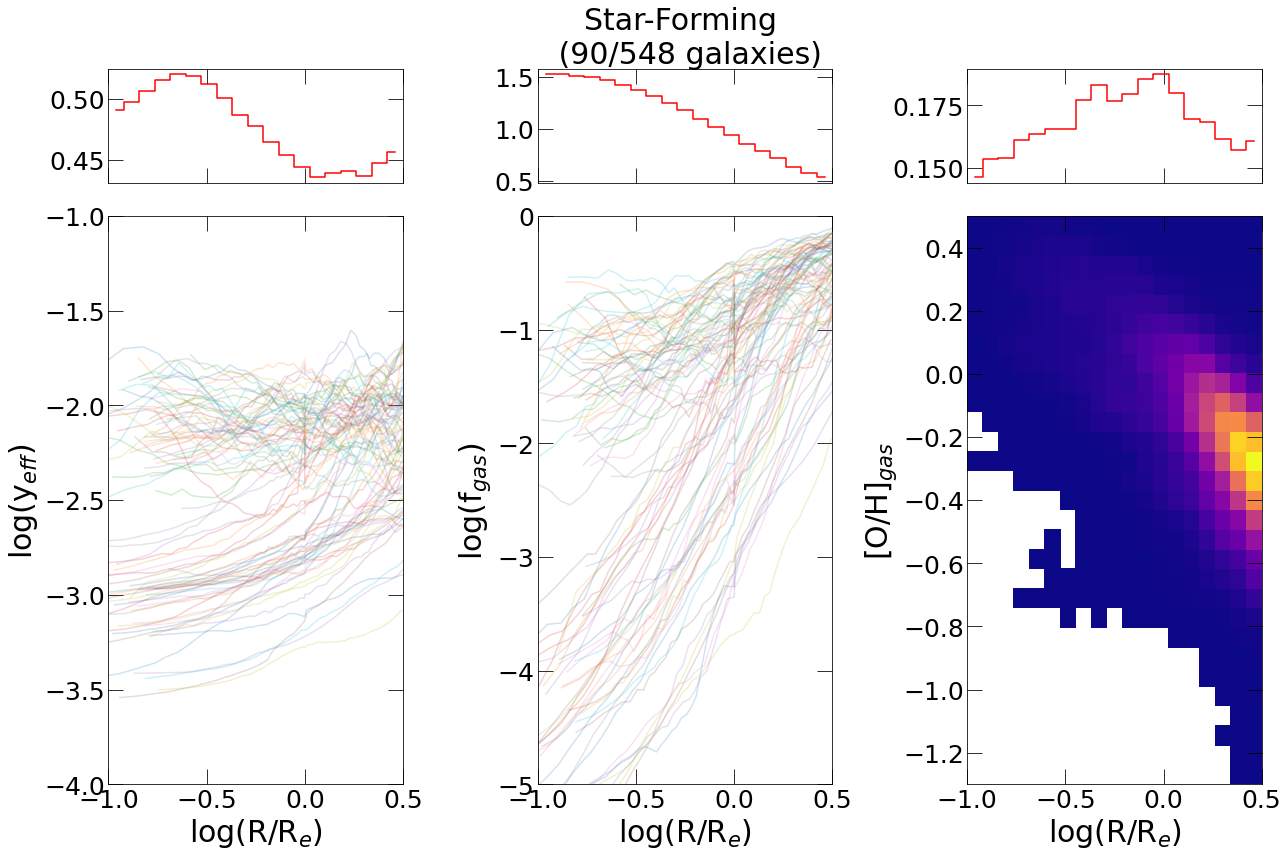

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-1, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
        big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
        big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
        h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
        big_h3 += h3

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R_star/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R_star/R_e), np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R_star/R_e), np.log10(f_gas), 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-1, 0.5)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-4, -1)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-1, 0.5)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-1, 0.5)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

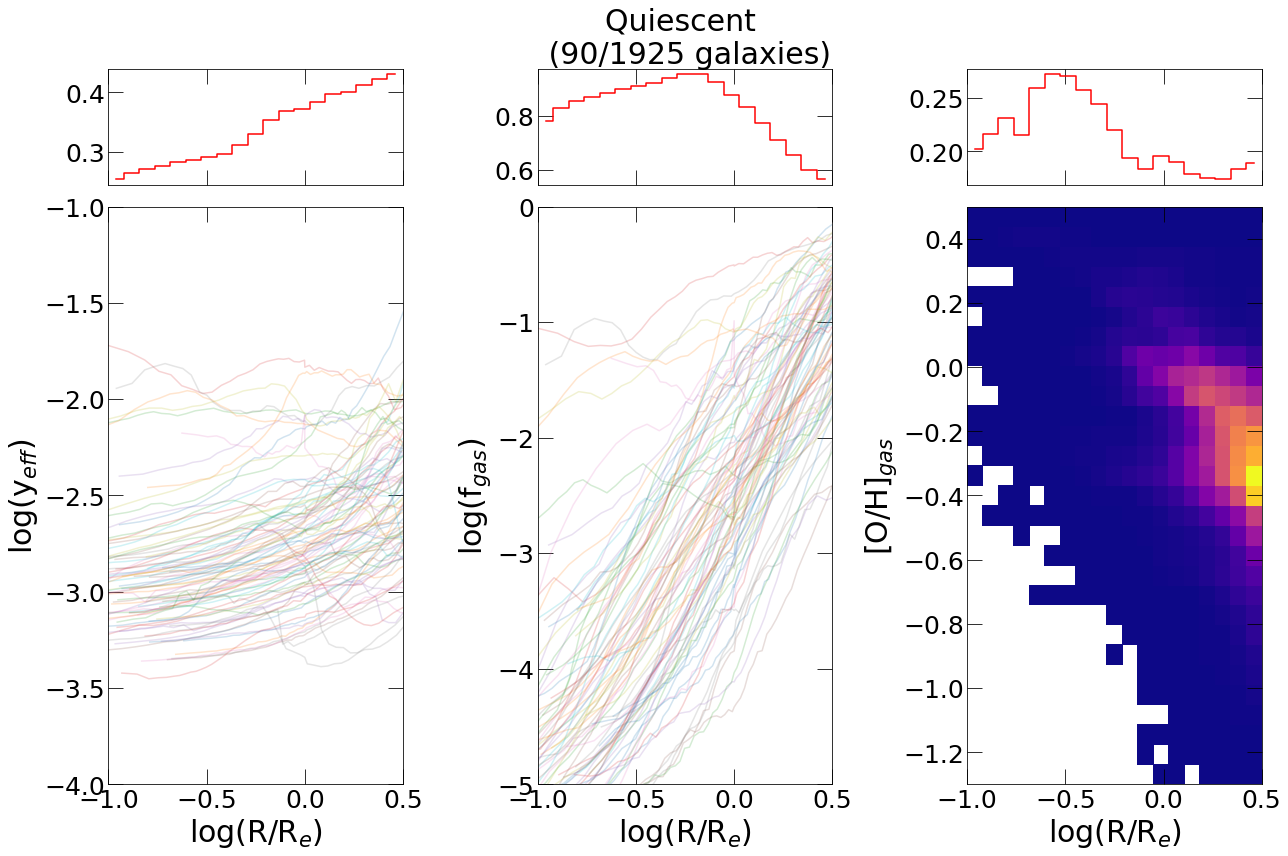

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-1, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
        big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
        big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
        h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
        big_h3 += h3

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R_star/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R_star/R_e), np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R_star/R_e), np.log10(f_gas), 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-1, 0.5)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-4, -1)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-1, 0.5)
#     ax[1].set_xscale('log')
#     ax[1].set_xticks([0.2, 1, 10], minor=False)
#     ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(-1, 0.5)
#     ax[2].set_xscale('log')
#     ax[2].set_xticks([0.2, 1, 10], minor=False)
#     ax[2].set_xticklabels(['0.2', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.3, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

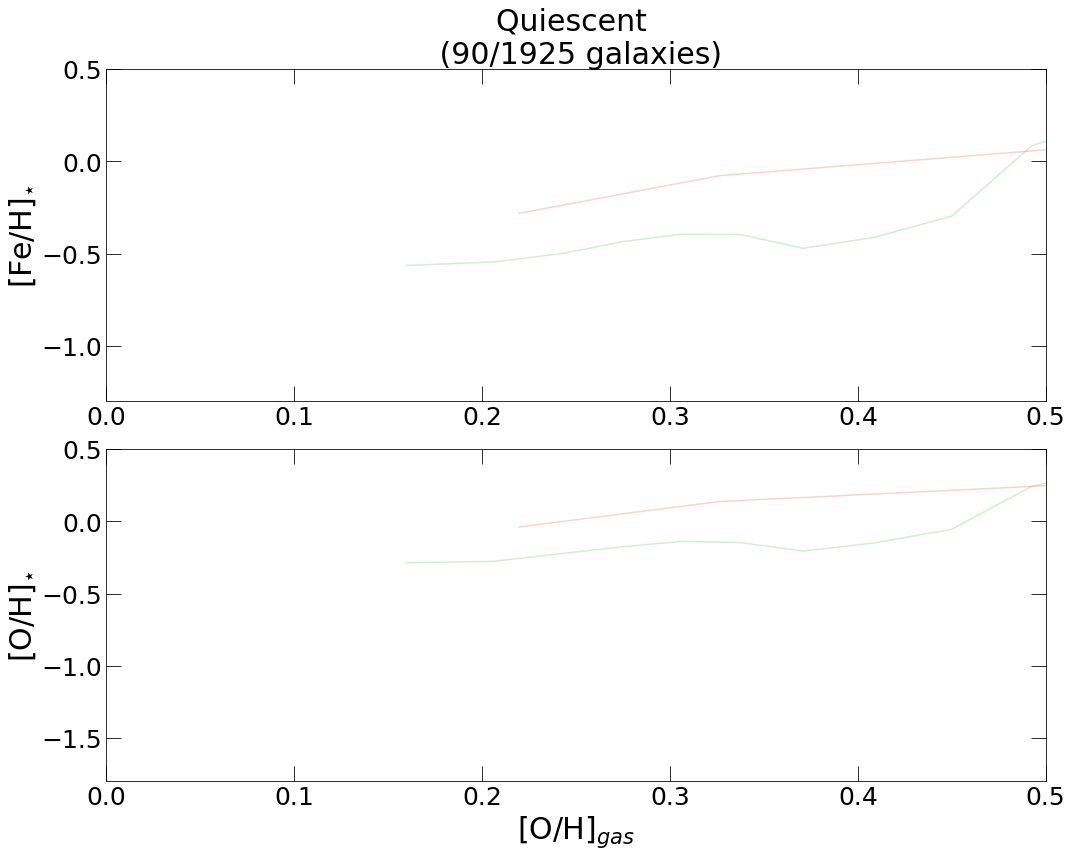

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(Z_gas, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(Z_gas, OH_star, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
# ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

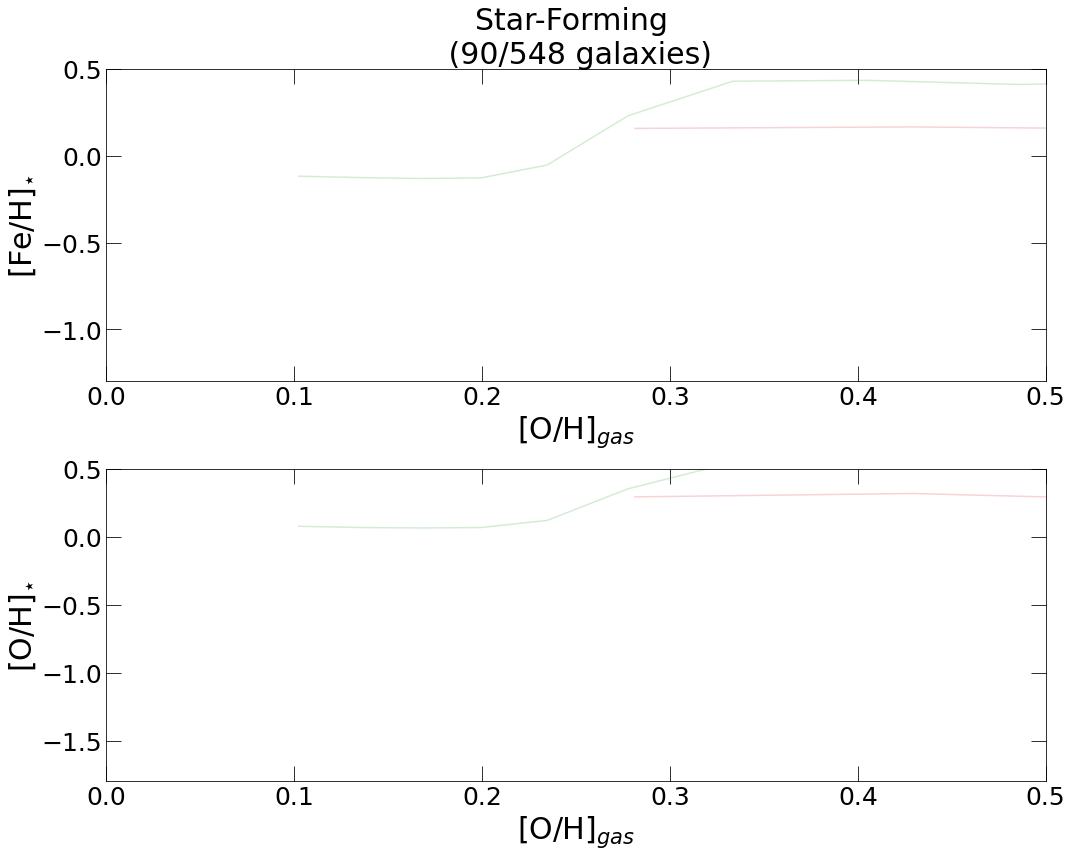

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(Z_gas, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(Z_gas, OH_star, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

## stellar and gas metallicities comparison

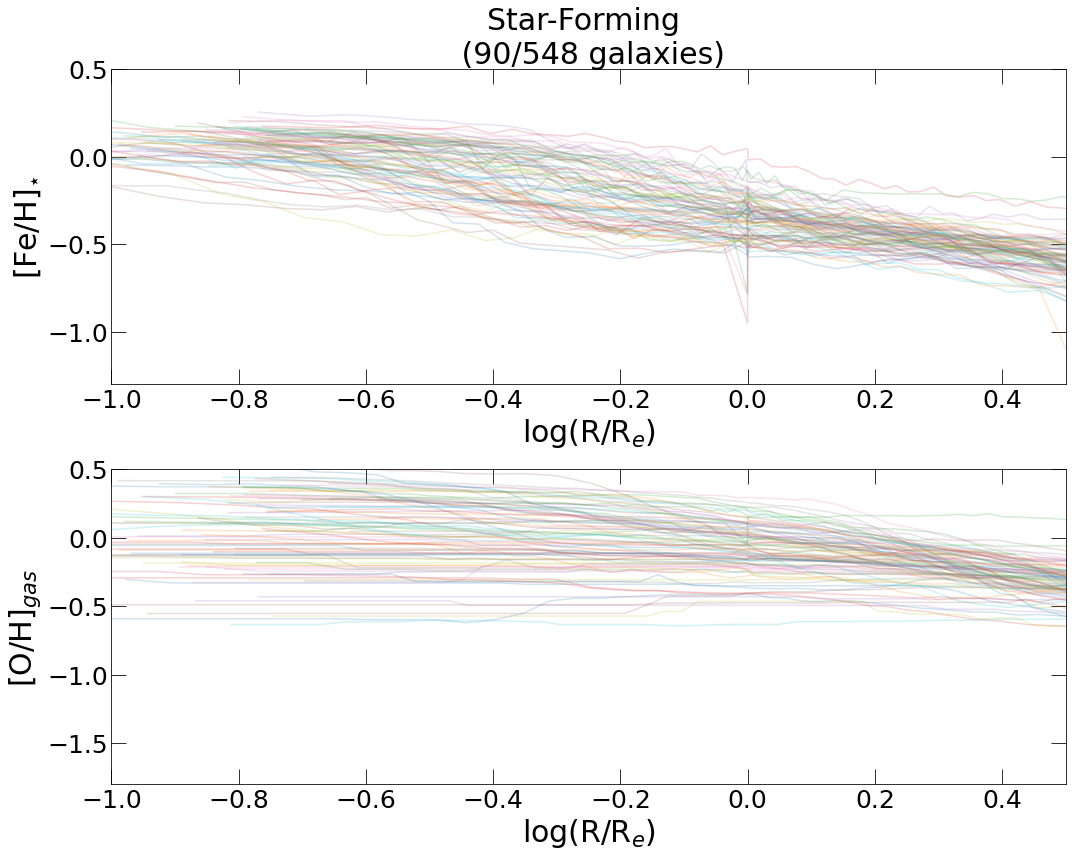

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-1, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, Z_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), Z_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1, 0.5)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

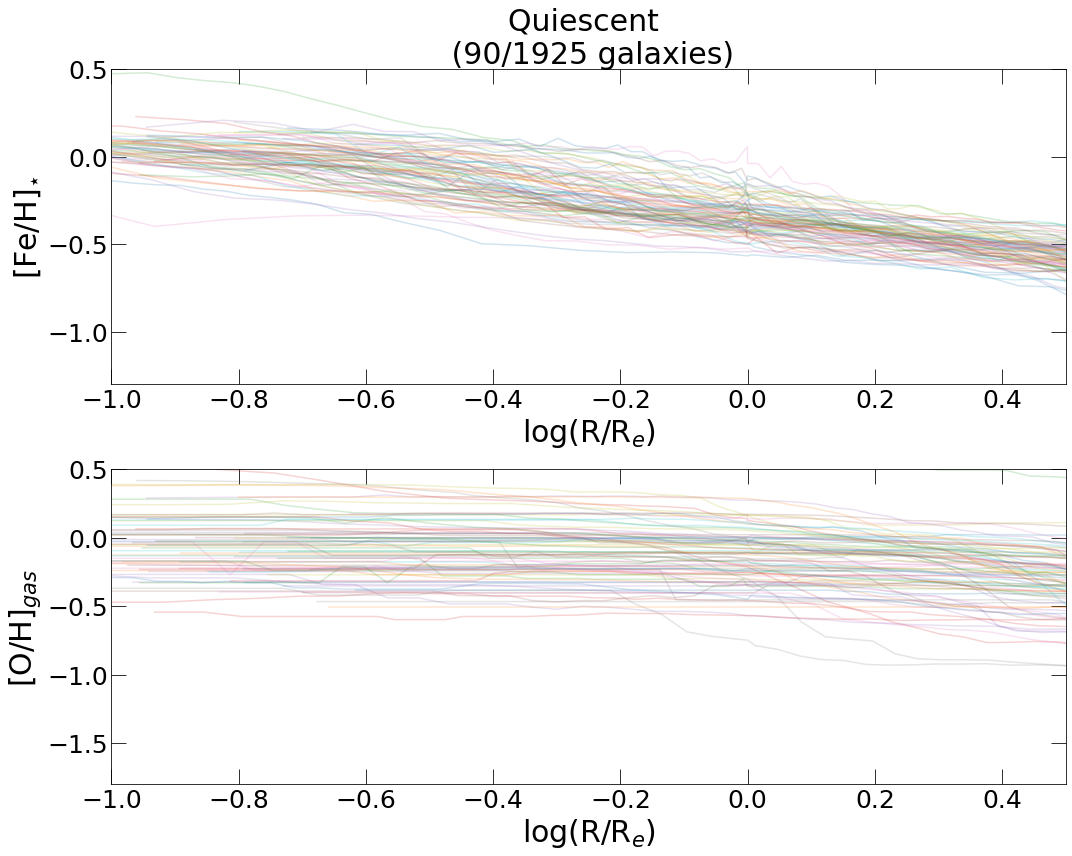

In [9]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-1, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, Z_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
        R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(np.log10(R/R_e), (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), Z_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(np.log10(R/R_e), Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1, 0.5)
#     ax[0].set_xscale('log')
#     ax[0].set_xticks([0.2, 1, 10], minor=False)
#     ax[0].set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

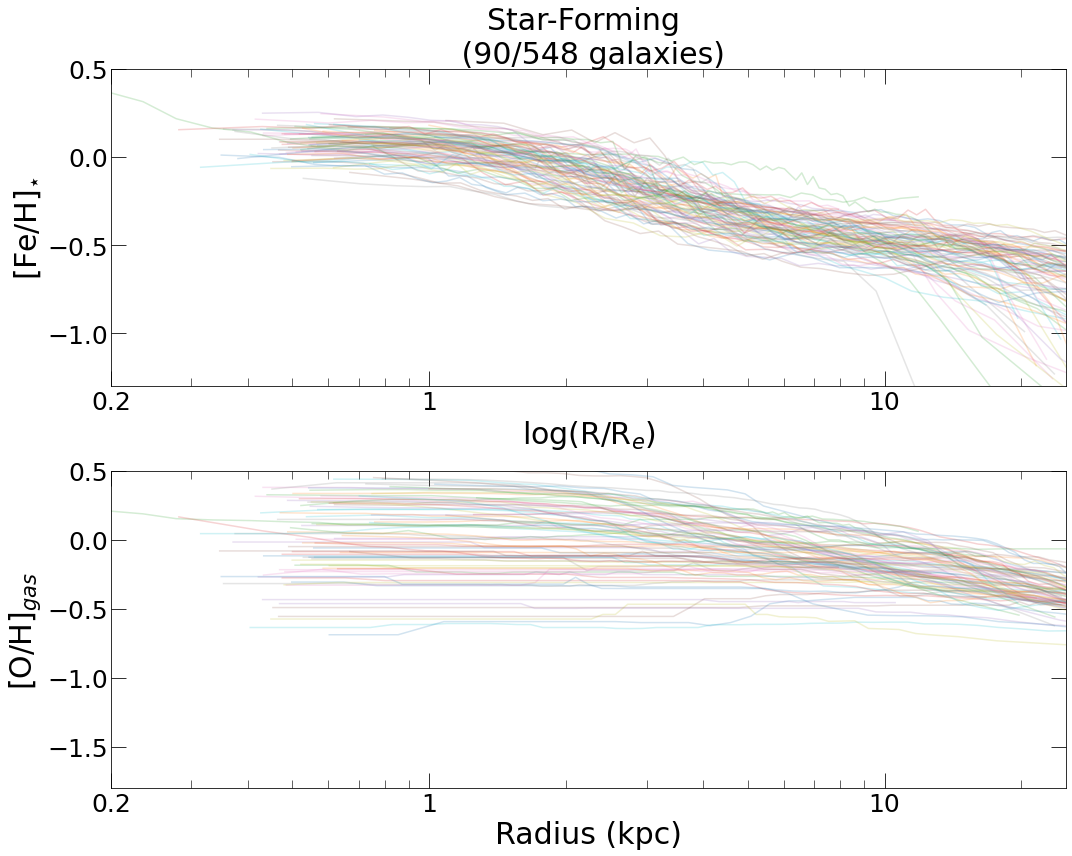

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, Z_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, Z_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0.2, 25)
    ax.set_xscale('log')
    ax.set_xticks([0.2, 1, 10], minor=False)
    ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

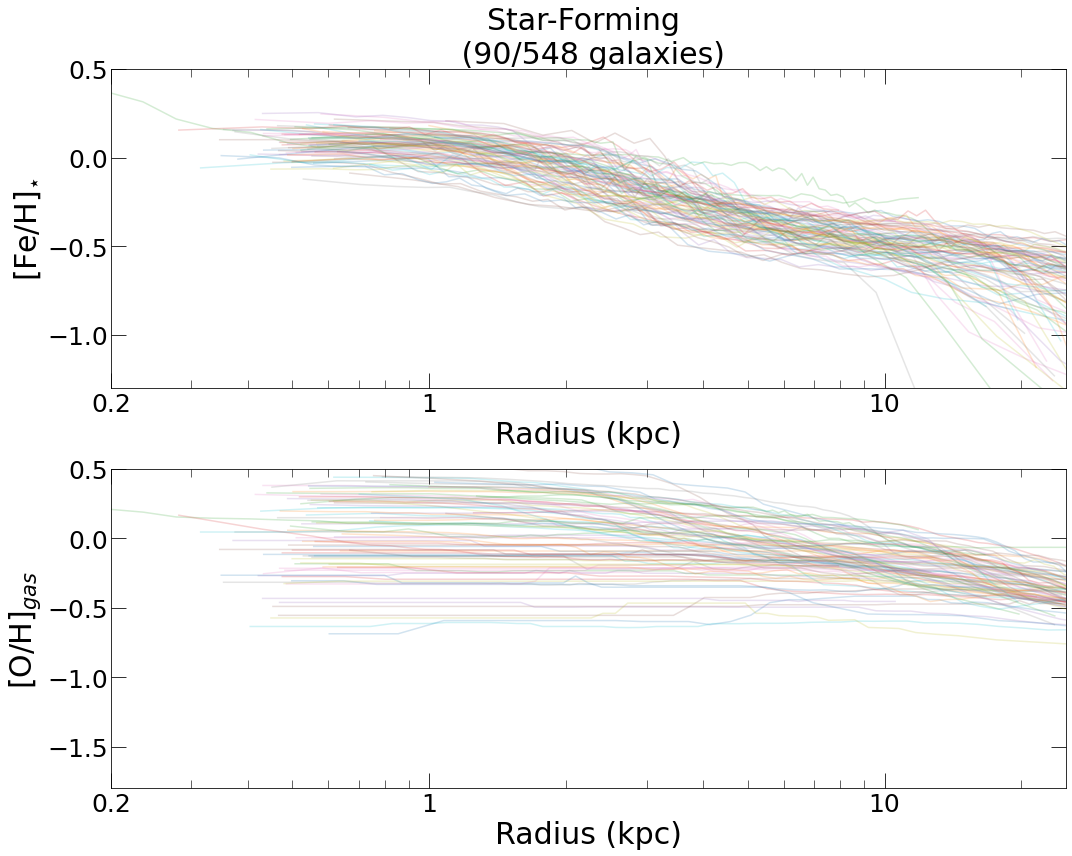

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, Z_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, Z_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0.2, 25)
    ax.set_xscale('log')
    ax.set_xticks([0.2, 1, 10], minor=False)
    ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

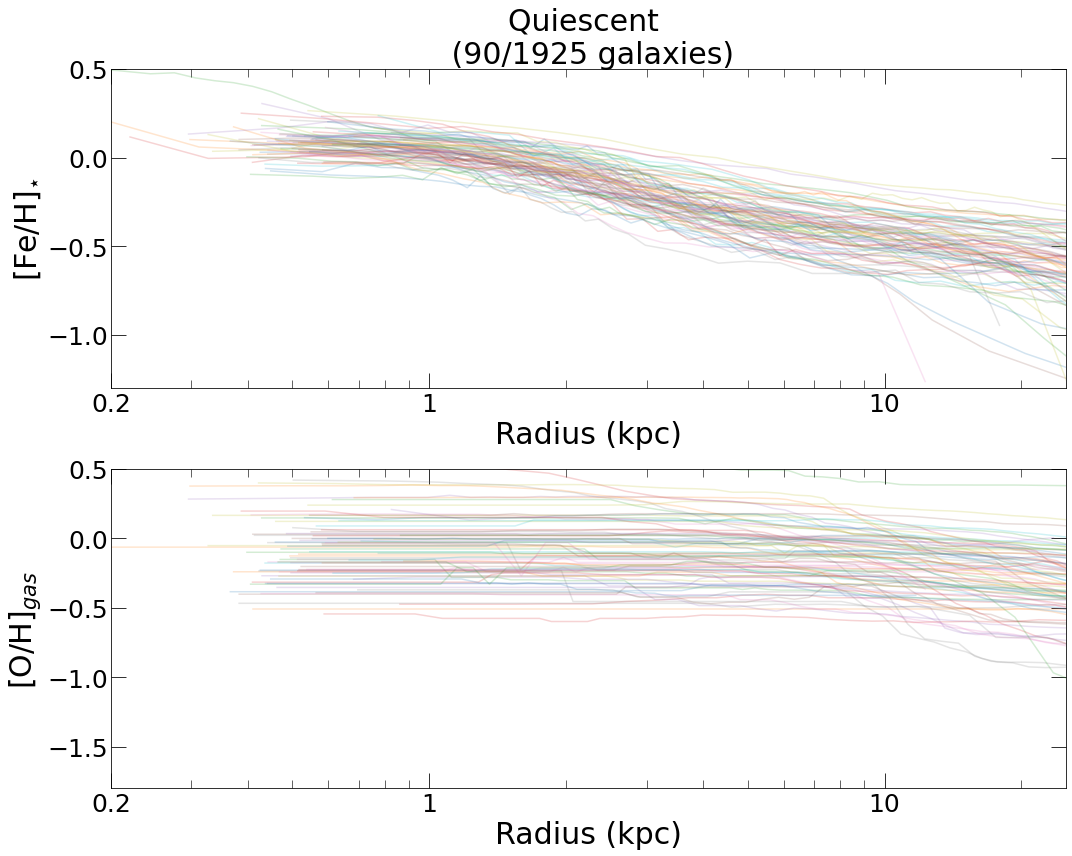

In [10]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, Z_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, Z_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0.2, 25)
    ax.set_xscale('log')
    ax.set_xticks([0.2, 1, 10], minor=False)
    ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

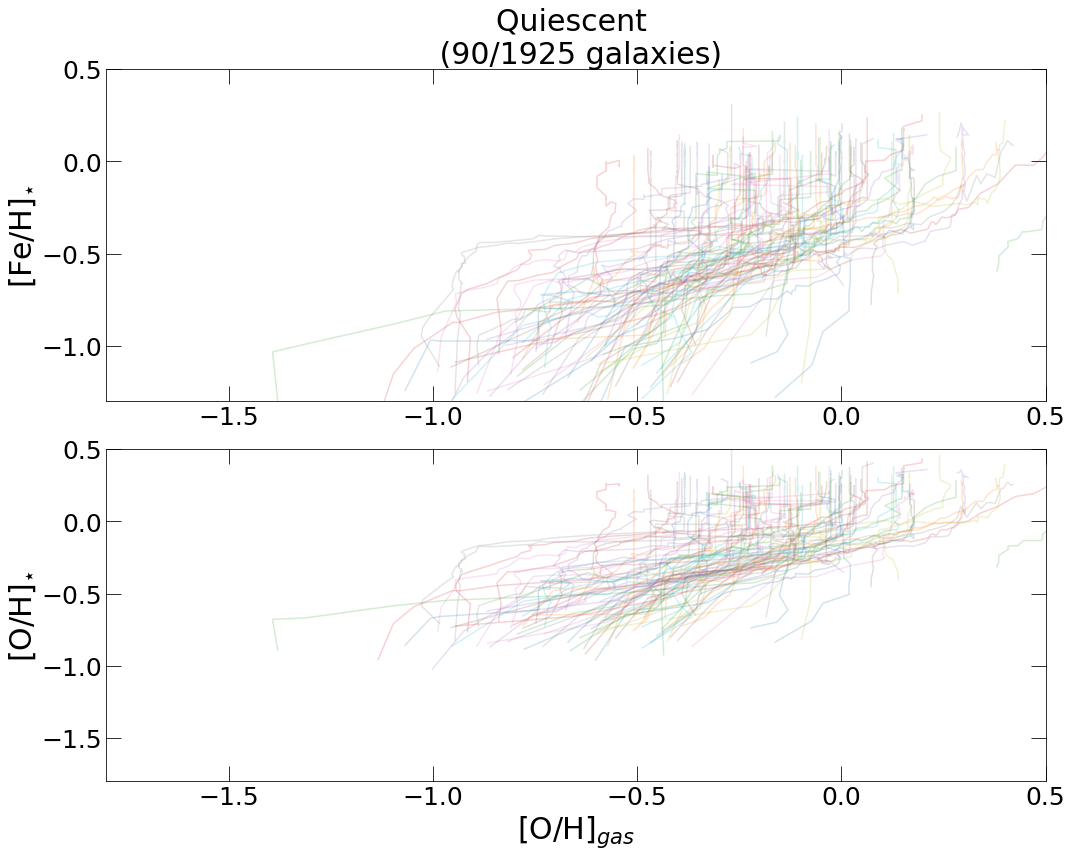

In [16]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles1 = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, OH_star, 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(stat3[1:], stat1[1:], alpha = 0.2)
        ax2.plot(stat3[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1.8, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
# ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

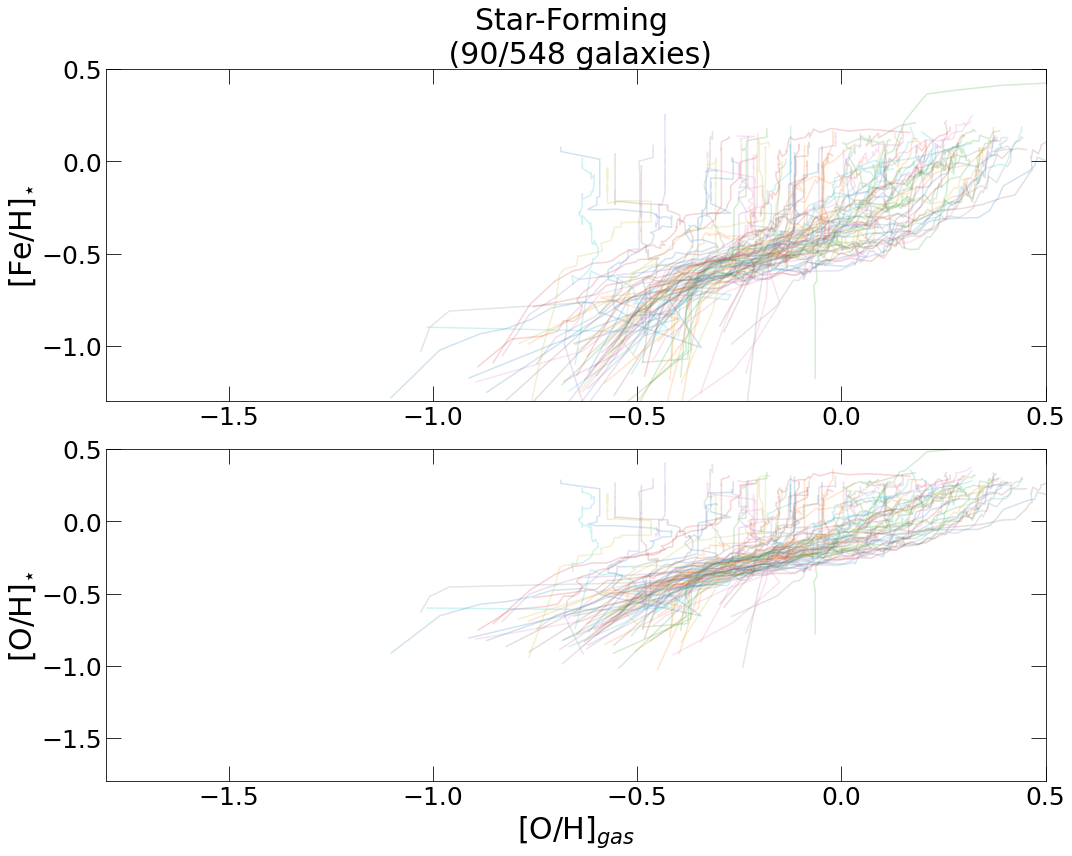

In [17]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles1 = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, OH_star, 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(stat3[1:], stat1[1:], alpha = 0.2)
        ax2.plot(stat3[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1.8, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
# ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

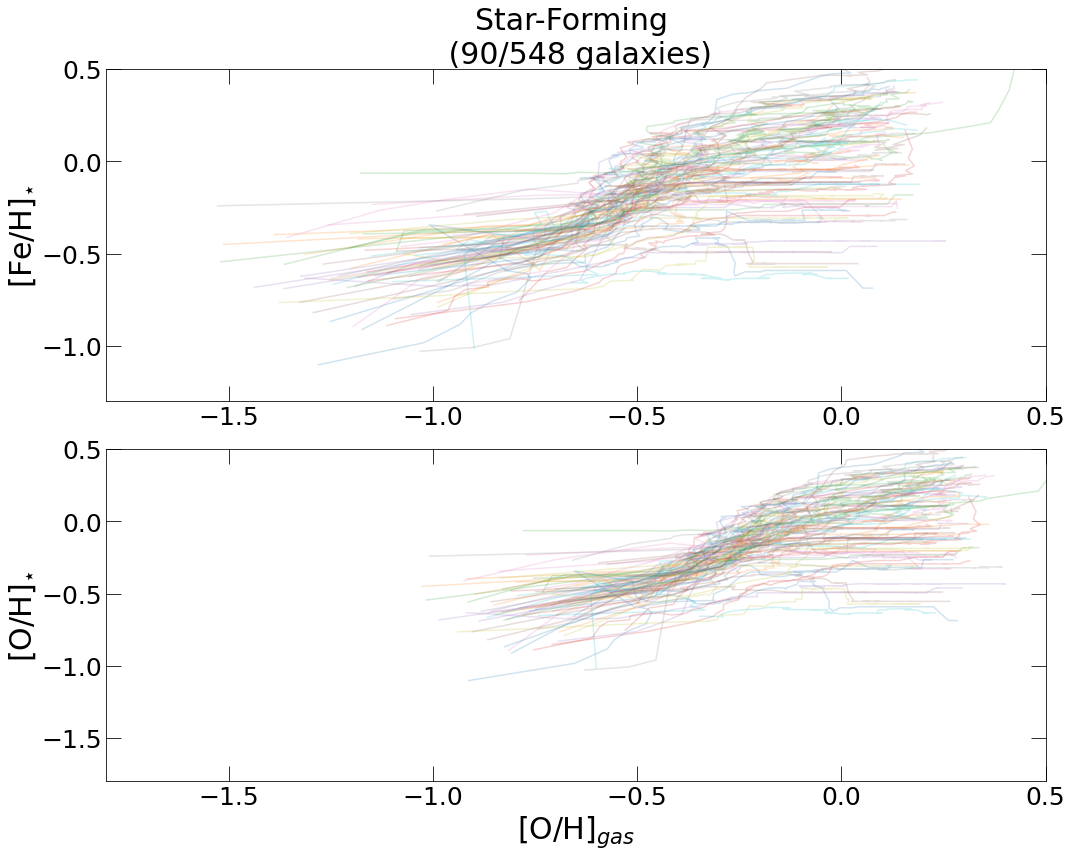

In [18]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles1 = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, OH_star, 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(stat1[1:], stat3[1:], alpha = 0.2)
        ax2.plot(stat2[1:], stat3[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1.8, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
# ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

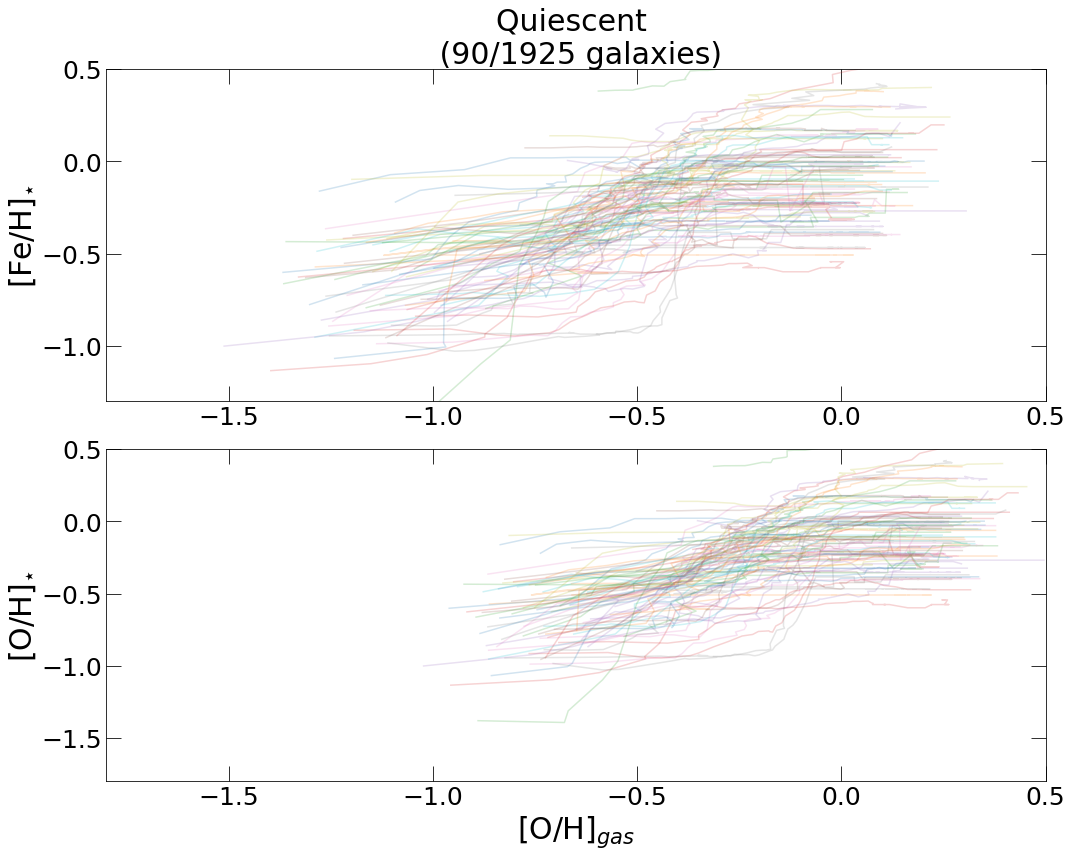

In [19]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles1 = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R, OH_star, 'median', bins=percentiles)
        stat3, _, _ = scipy.stats.binned_statistic(R, Z_gas, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(stat1[1:], stat3[1:], alpha = 0.2)
        ax2.plot(stat2[1:], stat3[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(-1.8, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
# ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Quiescent \n (90/' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

KeyboardInterrupt: 

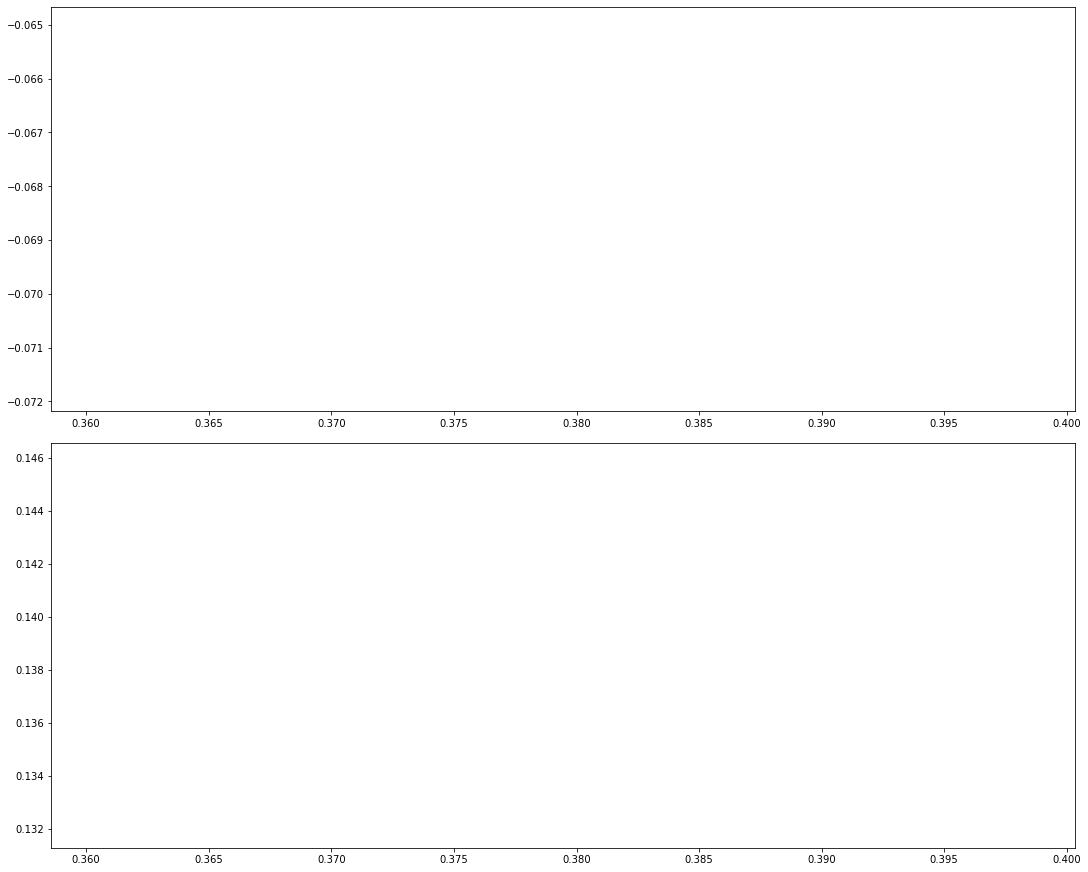

In [12]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 1, sharex='none', sharey='none', figsize=(15, 12), constrained_layout=True)
ax1 = axes[0]
ax2 = axes[1]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(0, 0.5, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-1.3, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 90, replace=False):
    R, FeH_star, Z_gas = stellar_gas_metallicities(id=id, redshift=redshift)
    if type(R) == int:
        pass
    else:
#         OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True)
#         R_e = halfmass_rad_stars(id, redshift)
#         big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
#         big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
#         big_R_star = np.concatenate((big_R_star, np.log10(R_star/R_e)), axis=None)
#         big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
#         big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
#         h3, _, _ = np.histogram2d(np.log10(R/R_e), OH_gas, bins=[xbins, metalbins], density=False)
#         big_h3 += h3

        # calculate statistic for profile
        OH_star = starmetals_only(id, redshift, 'oxygen', 'hydrogen')
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(Z_gas, FeH_star, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(Z_gas, OH_star, 'median', bins=percentiles)
        xx = percentiles[:-1]
        ax1.plot(xx[1:], stat1[1:], alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], alpha = 0.2)

# quantify scatter
# xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

# stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
# stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
# stat3, _, _ = stats.binned_statistic(big_R, big_OH_gas, 'std', bins=xbins)

# sc1.step(xbins_new, stat1, 'r', where='mid')
# sc2.step(xbins_new, stat2, 'r', where='mid')
# sc3.step(xbins_new, stat3, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax.set_xlim(0, 0.5)
#     ax.set_xscale('log')
#     ax.set_xticks([0.2, 1, 10], minor=False)
#     ax.set_xticklabels(['0.2', '1', '10'])
    ax.tick_params(which='major', length=15)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-1.3, 0.5)
# ax1.set_yscale('log')
ax1.set_ylabel("[Fe/H]$_{\star}$", fontsize=fts)
ax1.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
# for ax in axes:
#     ax[1].set_xlim(0, 0.5)
# #     ax[1].set_xscale('log')
# #     ax[1].set_xticks([0.2, 1, 10], minor=False)
# #     ax[1].set_xticklabels(['0.2', '1', '10'])
#     ax[1].tick_params(which='major', length=15)
#     ax[1].tick_params(which='minor', length=8)
#     ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[O/H]$_{\star}$", fontsize=fts)
ax2.set_xlabel('[O/H]$_{gas}$', fontsize=fts)

# big_h3[big_h3==0] = np.nan
# color=colormap(norm(big_h3)).tolist()
# color = tuple(color[0][:])
# ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# # ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
# for ax in axes:
#     ax[2].set_xlim(0, 0.5)
# #     ax[2].set_xscale('log')
# #     ax[2].set_xticks([0.2, 1, 10], minor=False)
# #     ax[2].set_xticklabels(['0.2', '1', '10'])
#     ax[2].tick_params(which='major', length=15)
#     ax[2].tick_params(which='minor', length=8)
#     ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
# ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
# ax3.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
# ax3.set_ylim(-1.3, 0.5)
# # ax3.set_xscale('log')
# # ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

ax1.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

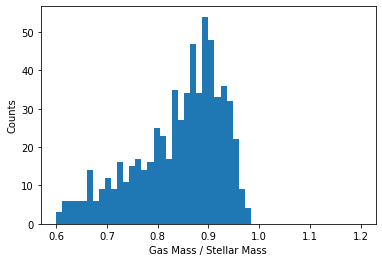

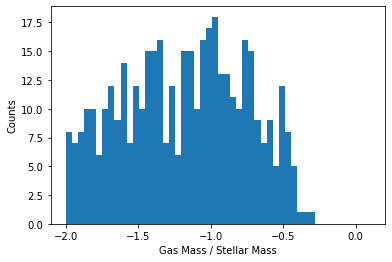

In [6]:
big_hist = []
for id in np.random.choice(ids, 1000, replace=False):
    mass_gas = total_gas_mass(id=id, redshift=redshift)
    if mass_gas > -1000:
        mass_star = float(total_mass[ids==id])
        big_hist.append(mass_gas - mass_star)
# print(big_hist)
plt.hist(big_hist, bins=50, range=(-2,0.1))
plt.xlabel('Gas Mass / Stellar Mass')
plt.ylabel('Counts')
plt.show()
    